# Import Libraries and Datasets

In [1]:
# EDA - Data Cleaning
import pandas as pd
import numpy as np
import missingno
from collections import Counter
import math

# EDA - Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.2f}'.format

# Define Function

In [2]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

In [3]:
excel_file = 'raw/Bank Customer Data 2020 Fall2.xlsx'

df = pd.read_excel(excel_file, sheet_name='Customer', index_col='UNIQUE_KEY')
print('Customer dataset shape: ', df.shape)

third = pd.read_excel(excel_file, sheet_name='3rd Party Data', index_col='UNIQUE_KEY')
print('Third Party dataset shape: ', third.shape)

dir_mail = pd.read_excel(excel_file, sheet_name='Direct Mail', index_col='UNIQUE_KEY')
print('Direct Mail dataset shape: ', dir_mail.shape)

email = pd.read_excel(excel_file, sheet_name='EMail', index_col='UNIQUE_KEY')
print('Email dataset shape: ', email.shape)

Customer dataset shape:  (5000, 30)
Third Party dataset shape:  (5002, 15)
Direct Mail dataset shape:  (3476, 3)
Email dataset shape:  (18581, 3)


In [4]:
df.columns = df.columns.str.replace(' ','_')
df.head(5)

annual_revenue  Month_on_Book Checking_avg_Bal Savings_avg_Bal Loans_LOC_avg_Bal CreditCard_avg_Bal CDs_avg_Bal HELoans_HELOC_avg_Bal MMDA_avg_Bal Branch_Visits_3_Mos Branch_Trans_3_Mos ATMVisits_3_Mos ATM_Trans_3_Mos signon_visit_3_Mos signon_trans_3_Mos CC_Visits_3_Mos VRU_visits_3_Mos BP_trans_3_Mos RDC_trans_3_Mos OLB_ENROLLED OLB_ACTIVE MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
UNIQUE_KEY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
763                 17.51            366           737.52               0                 0                  0           0                     0            0                   1                  1               6               8                 15                 19               0                0              3               0            1          1             .            1              1             0               0                0         0                   0          0
1813             10157.61            350            23030               0                 0                  0   445381.13                     0            0                   6                  6               0               0                  0                  0               0                1              0               0            1          .             .            0              1             0               0                0         1                   0          0
3743              1127.88            299          7873.71        32603.16                 0            1146.36           0                     0            0                   1                  2               8              10                 23                 28               0                0              0               0            1          1             .            1              1             1               0                1         0                   0          0
4180              1247.33            317          3412.20               0                 0            4751.32           0                     0            0                   3                  4              23              37                 15                 20               0                2              0               0            1          1             .            1              1             0               0                1         0                   0          0
8222                33.41            272          1187.24               0                 0                  0           0                     0            0                   0                  0               1               2                 19                 21               0                0              0               0            1          1             1            2              1             0               0                0         0                   0          0

In [5]:
df.describe()

Month_on_Book  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
count        5000.00      5000.00        5000.00       5000.00         5000.00          5000.00   5000.00             5000.00    5000.00
mean          191.36         1.14           0.90          0.19            0.18             0.30      0.04                0.11       0.20
std           167.64         0.80           0.29          0.40            0.38             0.46      0.19                0.31       0.40
min             1.00         0.00           0.00          0.00            0.00             0.00      0.00                0.00       0.00
25%            52.00         0.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
50%           154.00         1.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
75%           297.00         2.00           1.00          0.00            0.00             1.00      0.00                0.00       0.00
max          1418.00         2.00           1.00          1.00            1.00             1.00      1.00                1.00       1.00

# Data Due Diligence

## Customer Dataset

<b> Note: </b> After reviewing the dataset initially, I found '.' characters scattered throughout many of the numeric columns, so I am going to replace these values with null values and review as if they are missing.

In [6]:
df = df.replace('.', np.nan)
df

annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
UNIQUE_KEY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
763                  17.51            366            737.52             0.00               0.00                0.00         0.00                   0.00          0.00                 1.00                1.00             6.00             8.00               15.00               19.00             0.00              0.00            3.00             0.00          1.00        1.00            nan            1              1             0               0                0         0                   0          0
1813              10157.61            350          23030.00             0.00               0.00                0.00    445381.13                   0.00          0.00                 6.00                6.00             0.00             0.00                0.00                0.00             0.00              1.00            0.00             0.00          1.00         nan            nan            0              1             0               0                0         1                   0          0
3743               1127.88            299           7873.71         32603.16               0.00             1146.36         0.00                   0.00          0.00                 1.00                2.00             8.00            10.00               23.00               28.00             0.00              0.00            0.00             0.00          1.00        1.00            nan            1              1             1               0                1         0                   0          0
4180               1247.33            317           3412.20             0.00               0.00             4751.32         0.00                   0.00          0.00                 3.00                4.00            23.00            37.00               15.00               20.00             0.00              2.00            0.00             0.00          1.00        1.00            nan            1              1             0               0                1         0                   0          0
8222                 33.41            272           1187.24             0.00               0.00                0.00         0.00                   0.00          0.00                 0.00                0.00             1.00             2.00               19.00               21.00             0.00              0.00            0.00             0.00          1.00        1.00           1.00            2              1             0               0                0         0                   0          0
...                    ...            ...               ...              ...                ...                 ...          ...                    ...           ...                  ...                 ...              ...              ...                 ...                 ...              ...               ...             ...              ...           ...         ...            ...          ...            ...           ...             ...              ...      

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 763 to 6060102
Data columns (total 30 columns):
annual_revenue           4992 non-null float64
Month_on_Book            5000 non-null int64
Checking_avg_Bal         4979 non-null float64
Savings_avg_Bal          4979 non-null float64
Loans_LOC_avg_Bal        4979 non-null float64
CreditCard_avg_Bal       4979 non-null float64
CDs_avg_Bal              4979 non-null float64
HELoans_HELOC_avg_Bal    4979 non-null float64
MMDA_avg_Bal             4979 non-null float64
Branch_Visits_3_Mos      4992 non-null float64
Branch_Trans_3_Mos       4992 non-null float64
ATMVisits_3_Mos          4992 non-null float64
ATM_Trans_3_Mos          4992 non-null float64
signon_visit_3_Mos       4992 non-null float64
signon_trans_3_Mos       4992 non-null float64
CC_Visits_3_Mos          4992 non-null float64
VRU_visits_3_Mos         4992 non-null float64
BP_trans_3_Mos           4992 non-null float64
RDC_trans_3_Mos          4992 non-null float

Replacing the .'s worked. All values are now numeric so the next step is to begin reviewing columns with null values.

In [8]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
MOBILE_ACTIVE                  2997
OLB_ACTIVE                     1311
OLB_ENROLLED                    640
Checking_avg_Bal                 21
Savings_avg_Bal                  21
Loans_LOC_avg_Bal                21
CreditCard_avg_Bal               21
CDs_avg_Bal                      21
HELoans_HELOC_avg_Bal            21
MMDA_avg_Bal                     21
signon_trans_3_Mos                8
signon_visit_3_Mos                8
Branch_Visits_3_Mos               8
Branch_Trans_3_Mos                8
ATMVisits_3_Mos                   8
ATM_Trans_3_Mos                   8
annual_revenue                    8
CC_Visits_3_Mos                   8
VRU_visits_3_Mos                  8
BP_trans_3_Mos                    8
RDC_trans_3_Mos                   8

The MOBILE_ACTIVE, OLB_ACTIVE, AND OLB_ENROLLED columns have many nulls but look to be binary in nature. Below review the value counts for each before I can make any assumptions.

In [9]:
print(pd.value_counts(df['MOBILE_ACTIVE'], dropna=False), '\n')
print(pd.value_counts(df['OLB_ACTIVE'], dropna=False), '\n')
print(pd.value_counts(df['OLB_ENROLLED'], dropna=False))

nan     2997
1.00    2003
Name: MOBILE_ACTIVE, dtype: int64 

1.00    3689
nan     1311
Name: OLB_ACTIVE, dtype: int64 

1.00    4360
nan      640
Name: OLB_ENROLLED, dtype: int64


It is confirmed. Each column is missing its 0 binary value, so I will replace the nulls with 0 and rerun the code to assess the remaining null values.

In [10]:
df.MOBILE_ACTIVE.replace(np.NaN, 0, inplace=True)
df.OLB_ACTIVE.replace(np.NaN, 0, inplace=True)
df.OLB_ENROLLED.replace(np.NaN, 0, inplace=True)

In [11]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
Checking_avg_Bal                 21
Savings_avg_Bal                  21
Loans_LOC_avg_Bal                21
CreditCard_avg_Bal               21
CDs_avg_Bal                      21
HELoans_HELOC_avg_Bal            21
MMDA_avg_Bal                     21
signon_trans_3_Mos                8
CC_Visits_3_Mos                   8
Branch_Visits_3_Mos               8
Branch_Trans_3_Mos                8
ATMVisits_3_Mos                   8
ATM_Trans_3_Mos                   8
signon_visit_3_Mos                8
annual_revenue                    8
VRU_visits_3_Mos                  8
BP_trans_3_Mos                    8
RDC_trans_3_Mos                   8

In [12]:
df.loc[df['Checking_avg_Bal'].isnull()].describe()

annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
count           21.00          21.00              0.00             0.00               0.00                0.00         0.00                   0.00          0.00                21.00               21.00            21.00            21.00               21.00               21.00            21.00             21.00           21.00            21.00         21.00       21.00          21.00        21.00          21.00         21.00           21.00            21.00     21.00               21.00      21.00
mean           127.64          20.29               nan              nan                nan                 nan          nan                    nan           nan                 1.57                1.90             1.43             1.81                7.19               11.43             0.38              0.76            0.00             0.05          0.62        0.48           0.19         0.67           0.90          0.10            0.19             0.10      0.00                0.00       0.05
std            198.34          40.74               nan              nan                nan                 nan          nan                    nan           nan                 1.43                1.76             4.89             6.42               12.83               20.02             0.50              1.14            0.00             0.22          0.50        0.51           0.40         0.80           0.30          0.30            0.40             0.30      0.00                0.00       0.22
min              0.24           1.00               nan              nan                nan                 nan          nan                    nan           nan                 0.00                0.00             0.00             0.00                0.00                0.00             0.00              0.00            0.00             0.00          0.00        0.00           0.00         0.00           0.00          0.00            0.00             0.00      0.00                0.00       0.00
25%              8.40           1.00               nan              nan                nan                 nan          nan                    nan           nan                 1.00                1.00             0.00             0.00                0.00                0.00             0.00              0.00            0.00             0.00          0.00        0.00           0.00         0.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
50%             19.02           1.00               nan              nan                nan                 nan          nan                    nan           nan                 1.00                1.00             0.00             0.00                2.00                2.00             0.00              0.00            0.00             0.00          1.00        0.00           0.00         0.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
75%            113.28          17.00               nan              nan                nan                 nan          nan                    nan           nan                 2.00                3.00             0.00             0.00                5.00               11.00             1.00              1.00            0.00             0.00          1.00        1.00           0.00         1.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00

Many of the missing values look to be related to the same customers. Since there are only 21 (out of 5,000 records), it makes sense to filter them from the dataset.

In [13]:
df = df.loc[df['Checking_avg_Bal'].notnull()]

In [14]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
signon_trans_3_Mos                8
RDC_trans_3_Mos                   8
Branch_Visits_3_Mos               8
Branch_Trans_3_Mos                8
ATMVisits_3_Mos                   8
ATM_Trans_3_Mos                   8
signon_visit_3_Mos                8
CC_Visits_3_Mos                   8
VRU_visits_3_Mos                  8
BP_trans_3_Mos                    8
annual_revenue                    8

In [15]:
df.loc[df['signon_trans_3_Mos'].isnull()].describe()

annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
count            8.00           8.00              8.00             8.00               8.00                8.00         8.00                   8.00          8.00                 0.00                0.00             0.00             0.00                0.00                0.00             0.00              0.00            0.00             0.00          8.00        8.00           8.00         8.00           8.00          8.00            8.00             8.00      8.00                8.00       8.00
mean           448.99         105.00           8621.96             0.00             553.66              102.61      1258.58                5846.20       4753.34                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          0.88        0.75           0.62         1.38           1.00          0.00            0.12             0.12      0.12                0.12       0.25
std            603.68          65.81           8728.99             0.00            1565.99              290.22      3559.80               16535.56      13077.84                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          0.35        0.46           0.52         0.92           0.00          0.00            0.35             0.35      0.35                0.35       0.46
min             80.86          37.00           1904.60             0.00               0.00                0.00         0.00                   0.00          0.00                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          0.00        0.00           0.00         0.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
25%            109.34          41.50           2410.45             0.00               0.00                0.00         0.00                   0.00          0.00                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          1.00        0.75           0.00         0.75           1.00          0.00            0.00             0.00      0.00                0.00       0.00
50%            270.53         103.50           4547.89             0.00               0.00                0.00         0.00                   0.00          0.00                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          1.00        1.00           1.00         2.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
75%            388.84         140.75          12093.53             0.00               0.00                0.00         0.00                   0.00        229.29                  nan                 nan              nan              nan                 nan                 nan              nan               nan             nan              nan          1.00        1.00           1.00         2.00           1.00          0.00            0.00             0.00      0.00                0.00       0.25

Similar to the previous step, the 8 customers seem to all be missing values, so I will filter them out as well.

In [16]:
df = df.loc[df['Branch_Visits_3_Mos'].notnull()]

In [17]:
df.describe()

annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag
count         4963.00        4971.00           4971.00          4971.00            4971.00             4971.00      4971.00                4971.00       4971.00              4971.00             4971.00          4971.00          4971.00             4971.00             4971.00          4971.00           4971.00         4971.00          4971.00       4971.00     4971.00        4971.00      4971.00        4971.00       4971.00         4971.00          4971.00   4971.00             4971.00    4971.00
mean           750.27         192.22           7302.43          1883.46             873.82              594.49      3013.88                5717.85       7063.17                 2.12                2.83             7.14            11.11               34.54               64.64             0.35              1.04            2.66             0.47          0.87        0.74           0.40         1.14           0.90          0.19            0.18             0.30      0.04                0.11       0.20
std           1409.62         167.68          25022.43          8623.05            5683.93             2248.04     26702.53               28451.77      38333.36                 3.45                4.97            12.04            21.16               42.58              113.01             1.11              4.15            8.65             2.37          0.33        0.44           0.49         0.80           0.29          0.40            0.38             0.46      0.19                0.31       0.40
min         -15248.04           2.00           -777.94           -49.55             -16.67            -4856.31         0.00                -333.33        -84.17                 0.00                0.00             0.00             0.00                0.00                0.00             0.00              0.00            0.00             0.00          0.00        0.00           0.00         0.00           0.00          0.00            0.00             0.00      0.00                0.00       0.00
25%             73.38          53.00            370.25             0.00               0.00                0.00         0.00                   0.00          0.00                 0.00                0.00             0.00             0.00                1.00                1.00             0.00              0.00            0.00             0.00          1.00        0.00           0.00         0.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
50%            292.15         155.00           1497.38             0.00               0.00                0.00         0.00                   0.00          0.00                 1.00                1.00             2.00             2.00               17.00               21.00             0.00              0.00            0.00             0.00          1.00        1.00           0.00         1.00           1.00          0.00            0.00             0.00      0.00                0.00       0.00
75%            862.58         298.00           5289.56             0.00               0.00                0.00         0.00                   0.00          0.00                 3.00                4.00            10.00            14.00               56.00               81.00             0.00              1.00            0.00             0.00          1.00        1.00           1.00         2.00           1.00          0.00            0.00             1.00      0.00                0.00       0.00

In [18]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
annual_revenue                    8

Finally, there are 8 missing annual review values. I will replace these values with the median value.

In [19]:
df.annual_revenue.fillna(df.annual_revenue.median(), inplace=True)

In [20]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Empty DataFrame
Columns: [Amount]
Index: []

This concludes the missing values review. Up next, I will review the additional datasets to leverage the following sources:
+ 3rd Party Data
+ Direct Mail
+ Emails

## 3rd Party Dataset

In [21]:
third.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5002 entries, 763.0 to nan
Data columns (total 15 columns):
Customer Value          5000 non-null float64
Number_of_Children      5000 non-null object
Family_composition      5000 non-null object
Gender_P1               5000 non-null object
marital_status_P1       5000 non-null object
Dwelling_Type           5000 non-null object
Number_of_Adults        5002 non-null object
Length_of_Residence     5000 non-null object
Household_Age           5000 non-null object
Household_Size          5000 non-null object
HH_EDUCATION_VALUE      5000 non-null object
HH_INCOME2              5000 non-null object
Occupation              5000 non-null object
Liquid_Resources        5000 non-null object
Investment_Resources    5000 non-null object
dtypes: float64(1), object(14)
memory usage: 625.2+ KB


In [22]:
third.head(5)

Customer Value Number_of_Children Family_composition Gender_P1 marital_status_P1 Dwelling_Type Number_of_Adults Length_of_Residence Household_Age Household_Size HH_EDUCATION_VALUE HH_INCOME2 Occupation Liquid_Resources Investment_Resources
UNIQUE_KEY                                                                                                                                                                                                                                                 
763.00              737.52                  .                  8         2                 1             1                2                   7             7              2                  4          6         14                8                    5
1813.00          468411.13                  .                  8         2                 1             1                2                   8             6              2                  2          3         13                3                    3
3743.00           41623.23                  .                 14         2                 2             1                2                   8             5              2                  2          6         14                5                    8
4180.00            8163.53                  .                  6         1                 2             1                2                   8             4              2                  3          2          0                1                    2
8222.00            1187.24                  .                 14         2                 2             5                1                   4             2              1                  4          4          0                7                    4

In [23]:
third.describe()

Customer Value
count         5000.00
mean         26329.52
std          63029.22
min           -777.94
25%            938.83
50%           5195.71
75%          22963.28
max        1549653.03

Again, there looks to be many .'s where missing values should be.

In [24]:
third = third.replace('.', np.nan)

In [25]:
pd.value_counts(third['Family_composition'], dropna=False)

2.00     1362
14.00     977
12.00     962
1.00      710
nan       220
8.00      183
6.00      137
13.00     128
7.00       92
4.00       85
11.00      74
5.00       48
3.00       17
16.00       5
10.00       2
Name: Family_composition, dtype: int64

In [26]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(third.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
Number_of_Children             3933
Family_composition              220
Investment_Resources            187
Liquid_Resources                187
Occupation                       98
Dwelling_Type                    93
HH_EDUCATION_VALUE               36
Household_Size                   36
Household_Age                    36
Length_of_Residence              36
Number_of_Adults                 34
HH_INCOME2                        2
marital_status_P1                 2
Gender_P1                         2
Customer Value                    2

After reviewing the missing values, I am going to take the following steps:
+ Number_of_Children - replace missing values with 0 (according to the data dictionary, missing = 0
+ Occupation - NaN is replace with '00', as this is classified as Unknown
+ Dwelling_Type - NaN is replaed with 0, as this is classified as Unkown
+ Family_composition - filter out any nulls, as this may throw off many other variables associated

Note: Removing the 220 null values in Family_composition removed all other nulls for remaining columns. No nulls exist at this point in time.

In [27]:
third['Number_of_Children'].fillna(0, inplace=True)

In [28]:
third['Occupation'].fillna('00', inplace=True)
third['Dwelling_Type'].fillna(0, inplace=True)

third = third.loc[third['Family_composition'].notnull()]

## Direct Mail Dataset

The dataset provides each mailing to each customer and for what reason. After my initial assessment I am going to transform the data by doing the following:

+ Removing the Send_DATE column since I care about the number of mailings more so than when they were sent
+ Grouping the data by the type of mailings completed for each customer

The outcome will create an individual row for each customer outlining the necessary fields for my analysis. 

Then the dataset will be joined to the original customer dataset flagging the type of direct mail contact that was made to a customer (1 = yes, 0 = no).

In [29]:
dir_mail

Campaign_Name  Send_DATE Product_category
UNIQUE_KEY                                          
8222          RTXCBK0719 2019-07-09      Creidt Card
8222          RTXLAT0519 2019-06-04      Credit Card
8222          RTXUPL0919 2019-09-03           Credit
9362          RTXUPL0719 2019-07-09           Credit
9362          RTXUPL0919 2019-09-03           Credit
...                  ...        ...              ...
6052608       RTXCBK0919 2019-09-03      Creidt Card
6053715       RTXCBK0719 2019-07-09      Creidt Card
6053715       RTXCBK0919 2019-09-03      Creidt Card
6053715       RTXLAT0519 2019-06-04      Credit Card
6060102       RTXUPL0919 2019-09-03           Credit

[3476 rows x 3 columns]

In [30]:
pd.value_counts(dir_mail['Product_category'])

Creidt Card          1529
Credit               1140
Credit Card           773
Auto-Refinance         21
Home Equity (ITA)      13
Name: Product_category, dtype: int64

In [31]:
dir_mail['Product_category'].replace(to_replace={'Creidt Card':'Credit Card', 'Credit':'Credit Card'}, inplace=True)

In [32]:
dir_mail = dir_mail.groupby(by=['UNIQUE_KEY', 'Product_category']).agg('count').reset_index()
dir_mail.drop(columns=['Send_DATE'], inplace=True)
dir_mail.set_index('UNIQUE_KEY', inplace=True)
dir_mail

Product_category  Campaign_Name
UNIQUE_KEY                                  
8222              Credit Card              3
9362              Credit Card              2
15870             Credit Card              1
18084             Credit Card              1
21086             Credit Card              1
...                       ...            ...
5934059     Home Equity (ITA)              1
5947040           Credit Card              3
6052608           Credit Card              2
6053715           Credit Card              3
6060102           Credit Card              1

[1875 rows x 2 columns]

In [33]:
dir_mail = dir_mail.pivot_table(values='Campaign_Name', 
                                index=dir_mail.index, 
                                columns='Product_category', 
                                aggfunc='count').fillna(0).astype(int)

dir_mail['DirectMail_SENT'] = 1

In [34]:
dir_mail.columns = dir_mail.columns.str.replace(' ','_')
dir_mail.columns = dir_mail.columns.str.replace('-','_')
dir_mail.columns = dir_mail.columns.str.replace('(','')
dir_mail.columns = dir_mail.columns.str.replace(')','')
dir_mail

Product_category  Auto_Refinance  Credit_Card  Home_Equity_ITA  DirectMail_SENT
UNIQUE_KEY                                                                     
8222                           0            1                0                1
9362                           0            1                0                1
15870                          0            1                0                1
18084                          0            1                0                1
21086                          0            1                0                1
...                          ...          ...              ...              ...
5934059                        0            0                1                1
5947040                        0            1                0                1
6052608                        0            1                0                1
6053715                        0            1                0                1
6060102                        0            1                0                1

[1858 rows x 4 columns]

## Email Dataset

In [35]:
email

Campaign_Code ACTION_DATE ACTION_CODE
UNIQUE_KEY                                      
763           CCDCPS2019  2019-06-14        Send
763           RTXKAS0519  2019-06-03        Send
763           RTXOEM0719  2019-07-17        Send
763           CCDCPS2019  2019-06-19        Open
763           CCDCPS2019  2019-06-19       Click
...                  ...         ...         ...
6052608       RTXCBK0719  2019-07-23        Send
6052608       RTXOEM0719  2019-07-17        Send
6053715       RTXCBK0719  2019-07-23        Send
6053715       RTXOEM0719  2019-07-17        Send
6060102       CCDCPS2019  2019-07-19        Send

[18581 rows x 3 columns]

In [36]:
email = email.groupby(by=['UNIQUE_KEY', 'ACTION_CODE']).agg('count').reset_index()
email.drop(columns=['ACTION_DATE'], inplace=True)
email.set_index('UNIQUE_KEY', inplace=True)
email

ACTION_CODE  Campaign_Code
UNIQUE_KEY                           
763              Click              1
763               Open              1
763               Send              3
1813              Send              2
3743              Send              3
...                ...            ...
6050258           Send              4
6051481           Send              1
6052608           Send              2
6053715           Send              2
6060102           Send              1

[7247 rows x 2 columns]

In [37]:
email = email.pivot_table(values='Campaign_Code', 
                                index=email.index, 
                                columns='ACTION_CODE', 
                                aggfunc='count').fillna(0).astype(int)

email['Email_SENT'] = 1

In [38]:
email

ACTION_CODE  Click  Open  Send  Email_SENT
UNIQUE_KEY                                
763              1     1     1           1
1813             0     0     1           1
3743             0     0     1           1
4180             0     0     1           1
8222             0     1     1           1
...            ...   ...   ...         ...
6050258          0     0     1           1
6051481          0     0     1           1
6052608          0     0     1           1
6053715          0     0     1           1
6060102          0     0     1           1

[5000 rows x 4 columns]

# Join Datasets

## 3rd Party Dataset

In [39]:
print('Shape - Before: ', df.shape)
df1 = df.join(third)
print('Shape - After: ', df1.shape)

Shape - Before:  (4971, 30)
Shape - After:  (4971, 45)


After joining the 3rd party dataset, I need to be aware that I will not be missing values for a number of columns that I removed from the third part data set (218 customers impacted).

<b> Action: </b> I will be removing these 218 customers from the analysis to utilzie the 3rd part data for the entire set of customers.

In [40]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df1.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Amount
Columns With Missing Values        
Investment_Resources            218
Number_of_Adults                218
Liquid_Resources                218
Number_of_Children              218
Family_composition              218
Gender_P1                       218
marital_status_P1               218
Dwelling_Type                   218
Customer Value                  218
Length_of_Residence             218
Household_Size                  218
HH_EDUCATION_VALUE              218
HH_INCOME2                      218
Household_Age                   218
Occupation                      218

In [41]:
df1 = df1.loc[df1['Investment_Resources'].notnull()]
print('New Shape of df1 after taking action:', df1.shape)

New Shape of df1 after taking action: (4753, 45)


We now have 4,735 customers to use for the remainder of this analysis. I do not believe we wiped out a significant enough portion of the sample to prevent moving forward.

## Direct Mail Dataset

In [42]:
print('Shape - Before: ', df1.shape)
df2 = df1.join(dir_mail).fillna(0)
print('Shape - After: ', df2.shape)
df2

Shape - Before:  (4753, 45)
Shape - After:  (4753, 49)


annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag  Customer Value  Number_of_Children  Family_composition Gender_P1 marital_status_P1  Dwelling_Type  Number_of_Adults  Length_of_Residence  Household_Age  Household_Size  HH_EDUCATION_VALUE HH_INCOME2  Occupation  Liquid_Resources  Investment_Resources  Auto_Refinance  Credit_Card  Home_Equity_ITA  DirectMail_SENT
UNIQUE_KEY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
763                  17.51            366            737.52             0.00               0.00                0.00         0.00                   0.00          0.00                 1.00                1.00             6.00             8.00               15.00               19.00             0.00              0.00            3.00             0.00          1.00        1.00           0.00            1              1             0               0                0         0                   0          0          737.52                0.00                8.00         2                 1           1.00              2.00                 7.00           7.00            2.00                4.00          6       14.00              8.00                  5.00            0.00         0.00             0.00             0.00
1813              10157.61            350          23030.00             0.00               0.00                0.00    445381.13                   0.00          0.00                 6.00                6.00             0.00             0.00                0.00                0.00             0.00              1.00            0.00             0.00          1.00        0.00           0.00            0              1             0               0                0         1                   0          0       468411.13                0.00                8.00         2                 1           1.00              2.00                 8.00           6.00            2.00                2.00          3       13.00              3.00                  3.00            0.00         0.00             0.00             0.00
3743               1127.88            299           7873.71         32603.16               0.00             1146.36         0.00                   0.00          0.00                 1.00                2.00             8.00            10.00               23.00               28.00             0.00              0.00            0.00             0.00          1.00        1.00           0.00            1              1             1               0                1         0                   0          0        41623.23                0.00               14.00         2                 2           1.00              2.00                 8.00           5.00            2.00                2.00          6       14.00           

In [43]:
pd.value_counts(df2['DirectMail_SENT'], dropna=False)

0.00    2966
1.00    1787
Name: DirectMail_SENT, dtype: int64

## Email Dataset

In [44]:
print('Shape - Before: ', df2.shape)
df3 = df2.join(email).fillna(0)
print('Shape - After: ', df3.shape)
df3

Shape - Before:  (4753, 49)
Shape - After:  (4753, 53)


annual_revenue  Month_on_Book  Checking_avg_Bal  Savings_avg_Bal  Loans_LOC_avg_Bal  CreditCard_avg_Bal  CDs_avg_Bal  HELoans_HELOC_avg_Bal  MMDA_avg_Bal  Branch_Visits_3_Mos  Branch_Trans_3_Mos  ATMVisits_3_Mos  ATM_Trans_3_Mos  signon_visit_3_Mos  signon_trans_3_Mos  CC_Visits_3_Mos  VRU_visits_3_Mos  BP_trans_3_Mos  RDC_trans_3_Mos  OLB_ENROLLED  OLB_ACTIVE  MOBILE_ACTIVE  Active_user  Checking_flag  Savings_flag  Loans_LOC_flag  CreditCard_flag  CDs_flag  HELoans_HELOC_flag  MMDA_flag  Customer Value  Number_of_Children  Family_composition Gender_P1 marital_status_P1  Dwelling_Type  Number_of_Adults  Length_of_Residence  Household_Age  Household_Size  HH_EDUCATION_VALUE HH_INCOME2  Occupation  Liquid_Resources  Investment_Resources  Auto_Refinance  Credit_Card  Home_Equity_ITA  DirectMail_SENT  Click  Open  Send  Email_SENT
UNIQUE_KEY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
763                  17.51            366            737.52             0.00               0.00                0.00         0.00                   0.00          0.00                 1.00                1.00             6.00             8.00               15.00               19.00             0.00              0.00            3.00             0.00          1.00        1.00           0.00            1              1             0               0                0         0                   0          0          737.52                0.00                8.00         2                 1           1.00              2.00                 7.00           7.00            2.00                4.00          6       14.00              8.00                  5.00            0.00         0.00             0.00             0.00      1     1     1           1
1813              10157.61            350          23030.00             0.00               0.00                0.00    445381.13                   0.00          0.00                 6.00                6.00             0.00             0.00                0.00                0.00             0.00              1.00            0.00             0.00          1.00        0.00           0.00            0              1             0               0                0         1                   0          0       468411.13                0.00                8.00         2                 1           1.00              2.00                 8.00           6.00            2.00                2.00          3       13.00              3.00                  3.00            0.00         0.00             0.00             0.00      0     0     1           1
3743               1127.88            299           7873.71         32603.16               0.00             1146.36         0.00                   0.00          0.00                 1.00                2.00             8.00            10.00               23.00               28.00             0.00              0.00            0.00             0.00          1.00        1.00           0.00            1              1             1               0                1         0                   0          0        41623.23                0.00               14.00         2                 2           1.00

In [45]:
pd.value_counts(df3['Email_SENT'], dropna=False)

1    4753
Name: Email_SENT, dtype: int64

After reviewing, we send an email to all customers, so the column Email_SENT & Send can be dropped.

In [46]:
df3.drop(columns=['Email_SENT', 'Send'], inplace=True)

## Final Data Due Diligence Steps

## Final review of null values

In [47]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df3.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

Empty DataFrame
Columns: [Amount]
Index: []

## Review datatypes to ensure all datatypes are numeric in nature before continuing with the analysis

In [48]:
df3.select_dtypes(exclude='number').info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 3 columns):
Gender_P1            4753 non-null object
marital_status_P1    4753 non-null object
HH_INCOME2           4753 non-null object
dtypes: object(3)
memory usage: 308.5+ KB


In [49]:
pd.value_counts(df3['Gender_P1'], dropna=False)

1    2385
2    2289
       65
3      14
Name: Gender_P1, dtype: int64

In [50]:
df3.loc[df3['Gender_P1']==' '].Family_composition.value_counts()

12.00    20
14.00    18
2.00     12
1.00      4
6.00      3
5.00      2
4.00      2
8.00      2
16.00     1
11.00     1
Name: Family_composition, dtype: int64

Based on the above, my primary guestimate of missing values is to input 1 (male) in to the field. However, using the 'Family_composition' column values, I can better estimate the Gender_P1. 

Additionally, after reviewing the Gender_P1 column and seeing such a low number under the Neutral field, I have decided to simply replace 3 (neutral) with a 1 (male). This impact 15 of 50 customers and ensures the Gender_P1 column values are now binary in nature.

In [51]:
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==1), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==2), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==4), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==5), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==6), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==8), 'Gender_P1'] = 2
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==11), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==12), 'Gender_P1'] = 1
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==14), 'Gender_P1'] = 2
df3.loc[(df3['Gender_P1']==' ')&(df3['Family_composition']==16), 'Gender_P1'] = 3


df3['Gender_P1'] = df3['Gender_P1'].astype(int)
df3['Gender_P1'].replace(3, 1, inplace=True)

Marital Status: I am going to use the Family composition column to help use logic and determine what the marital status of the customer is.

In [52]:
pd.value_counts(df3['marital_status_P1'], dropna=False)

1    2549
2    1368
      836
Name: marital_status_P1, dtype: int64

In [53]:
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==1), 'marital_status_P1'] = 1
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==2), 'marital_status_P1'] = 1
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==3), 'marital_status_P1'] = 3
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==4), 'marital_status_P1'] = 3
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==5), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==6), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==7), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==8), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==11), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==12), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==13), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==14), 'marital_status_P1'] = 2
df3.loc[(df3['marital_status_P1']==' ')&(df3['Family_composition']==16), 'marital_status_P1'] = 2

df3['marital_status_P1'] = df3['marital_status_P1'].astype(int)

HH_INCOME2: I am going to use my best estimate and assume the following:
+ A = 1
+ B = 2
+ C = 3
+ D = 4

In [54]:
pd.value_counts(df3['HH_INCOME2'], dropna=False)

6    957
7    714
5    520
8    418
4    414
3    413
9    365
1    220
A    218
2    157
B    157
C    146
D     54
Name: HH_INCOME2, dtype: int64

In [55]:
df3['HH_INCOME2'].replace(to_replace={'A':1, 'B':2, 'C':3, 'D':4}, inplace=True)
df3['HH_INCOME2'] = df3['HH_INCOME2'].astype(int)

Re-run the code to look for any fields that are not numeric before completing this step.

In [56]:
df3.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 51 columns):
annual_revenue           4753 non-null float64
Month_on_Book            4753 non-null int64
Checking_avg_Bal         4753 non-null float64
Savings_avg_Bal          4753 non-null float64
Loans_LOC_avg_Bal        4753 non-null float64
CreditCard_avg_Bal       4753 non-null float64
CDs_avg_Bal              4753 non-null float64
HELoans_HELOC_avg_Bal    4753 non-null float64
MMDA_avg_Bal             4753 non-null float64
Branch_Visits_3_Mos      4753 non-null float64
Branch_Trans_3_Mos       4753 non-null float64
ATMVisits_3_Mos          4753 non-null float64
ATM_Trans_3_Mos          4753 non-null float64
signon_visit_3_Mos       4753 non-null float64
signon_trans_3_Mos       4753 non-null float64
CC_Visits_3_Mos          4753 non-null float64
VRU_visits_3_Mos         4753 non-null float64
BP_trans_3_Mos           4753 non-null float64
RDC_trans_3_Mos          4753 non-null float64
OL

# What variable defines business value? - Customer Value

Define customer value as the dependent variable of the linear regression model you’ll build
+ DV = Sum of balance across all accounts (total account balance)

Additionally, since the DV is the sum of all balances, I am going to remove the avg balances from the dataset as part of this analysis.

In [57]:
df3.drop(columns=['Checking_avg_Bal', 
                  'Savings_avg_Bal', 
                  'Loans_LOC_avg_Bal', 
                  'CreditCard_avg_Bal', 
                  'CDs_avg_Bal',
                  'HELoans_HELOC_avg_Bal', 
                  'MMDA_avg_Bal'], inplace=True)

In [58]:
#Rename Customer Value column to Customer_Value
df3.rename(columns={'Customer Value':'Customer_Value'}, inplace=True)

In [59]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4753 entries, 763 to 6060102
Data columns (total 44 columns):
annual_revenue          4753 non-null float64
Month_on_Book           4753 non-null int64
Branch_Visits_3_Mos     4753 non-null float64
Branch_Trans_3_Mos      4753 non-null float64
ATMVisits_3_Mos         4753 non-null float64
ATM_Trans_3_Mos         4753 non-null float64
signon_visit_3_Mos      4753 non-null float64
signon_trans_3_Mos      4753 non-null float64
CC_Visits_3_Mos         4753 non-null float64
VRU_visits_3_Mos        4753 non-null float64
BP_trans_3_Mos          4753 non-null float64
RDC_trans_3_Mos         4753 non-null float64
OLB_ENROLLED            4753 non-null float64
OLB_ACTIVE              4753 non-null float64
MOBILE_ACTIVE           4753 non-null float64
Active_user             4753 non-null int64
Checking_flag           4753 non-null int64
Savings_flag            4753 non-null int64
Loans_LOC_flag          4753 non-null int64
CreditCard_flag         4753 

# Exploratory Data Analysis

## Assess and Remove Outliers

### Remove Outliers from annual_revenue

In [60]:
def box_plot(df, col):
    feature_obj = list(enumerate([col]))
    plt.figure(figsize = (25,120))
    sns.set(font_scale = 1.3)

    for i in feature_obj:
        plt.subplot(12,2,i[0]+1)
        sns.boxplot(y = i[1],
                    data = df,
                    color='mediumseagreen')

    #     plt.ylabel('Customer Count')
        plt.title(str(i[1]))
        plt.ylabel('Value')
        plt.xticks(rotation = 45)

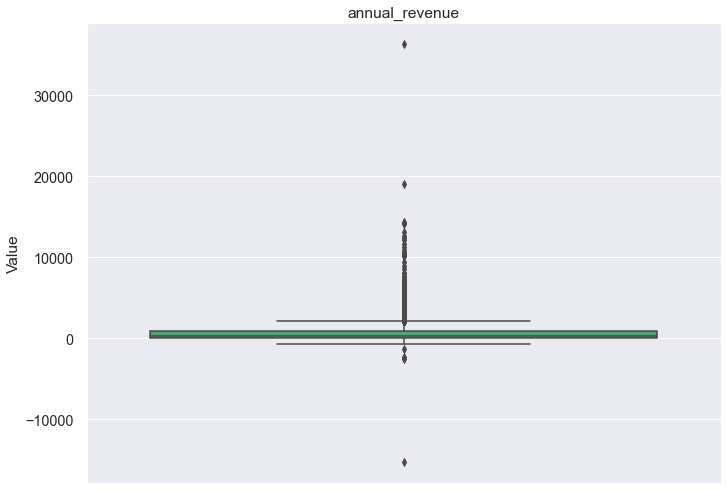

In [61]:
box_plot(df3, 'annual_revenue')

The below  function will loop through a list of features and detect outliers in each one of those features. In each loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds third quartile plus the outlier step. The outlier step is defined as 10 times the interquartile range. Once the outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next feature and the process repeats until the very last feature is completed.

In [62]:
col = 'annual_revenue'
outlier_indices = [] 
Q1 = np.percentile(df3[col], 25)
Q3 = np.percentile(df3[col], 75)
IQR = Q3 - Q1
outlier_step = 8 * IQR 
outlier_list_col = df3[(df3[col] < Q1 - outlier_step) | (df3[col] > Q3 + outlier_step)].index
outlier_indices.extend(outlier_list_col) 


print("We will drop these {} indices: ".format(len(outlier_indices)), outlier_indices)

We will drop these 27 indices:  [1813, 47254, 79802, 97272, 136235, 150324, 316619, 423237, 440648, 639406, 790955, 814851, 815160, 1048677, 1391099, 1522046, 1652254, 1868813, 1879821, 1965916, 2220292, 2952188, 3958125, 4969477, 5384891, 5470002, 5722259]


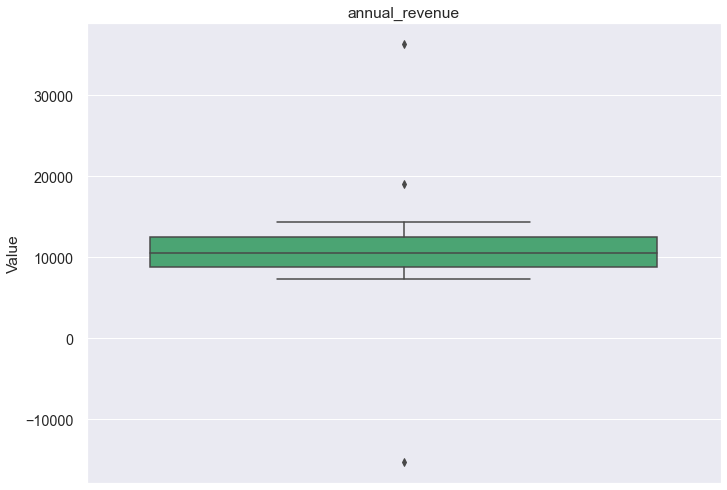

In [63]:
box_plot(df3.loc[outlier_indices, :,], 'annual_revenue')

In [64]:
print("Before: {} rows".format(len(df3)))
outliers = df3.loc[outlier_indices, :]
outliers['Outlier_Indicator'] = 'Yes'
outliers = outliers['Outlier_Indicator']
df4 = df3.join(outliers)
df4 = df4.loc[df4['Outlier_Indicator'].isnull()]
df4.drop(columns='Outlier_Indicator', inplace=True)
print("After: {} rows".format(len(df4)))

Before: 4753 rows
After: 4726 rows


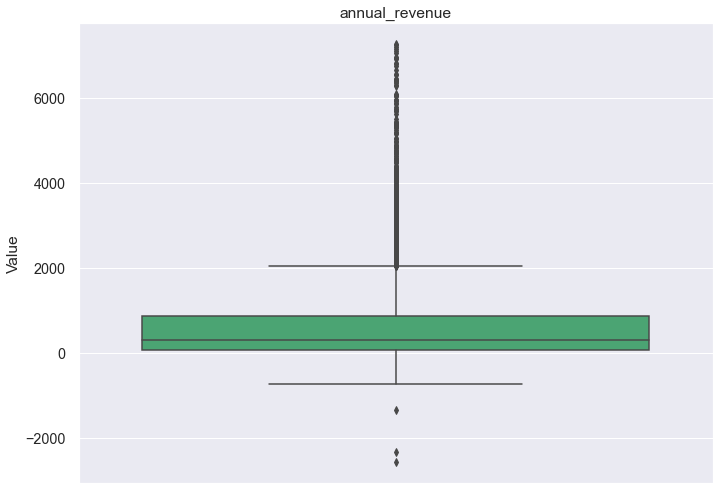

In [65]:
box_plot(df4, 'annual_revenue')

### Remove Outliers from Customer_Value

In [66]:
box_plot(df4, 'Customer_Value')

In [67]:
col = 'Customer_Value'
outlier_indices = [] 
Q1 = np.percentile(df4[col], 25)
Q3 = np.percentile(df4[col], 75)
IQR = Q3 - Q1
outlier_step = 10 * IQR 
outlier_list_col = df4[(df4[col] < Q1 - outlier_step) | (df4[col] > Q3 + outlier_step)].index
outlier_indices.extend(outlier_list_col) 
outlier_indices

print("We will drop these {} indices: ".format(len(outlier_indices)), outlier_indices)

We will drop these 55 indices:  [154741, 162290, 164631, 178195, 202864, 290253, 373559, 495805, 598378, 631799, 672053, 746510, 822159, 850258, 911275, 930610, 940296, 942350, 999716, 1071722, 1157294, 1264899, 1484374, 1532735, 1748405, 1893511, 1968284, 2066329, 2076021, 2093086, 2579391, 3185847, 3295416, 3758703, 3943909, 4213861, 4214326, 4226924, 4292230, 4392851, 4438016, 4538539, 4548422, 4582573, 4647487, 5016684, 5055399, 5079602, 5175807, 5327044, 5358059, 5366071, 5388611, 5604910, 5701153]


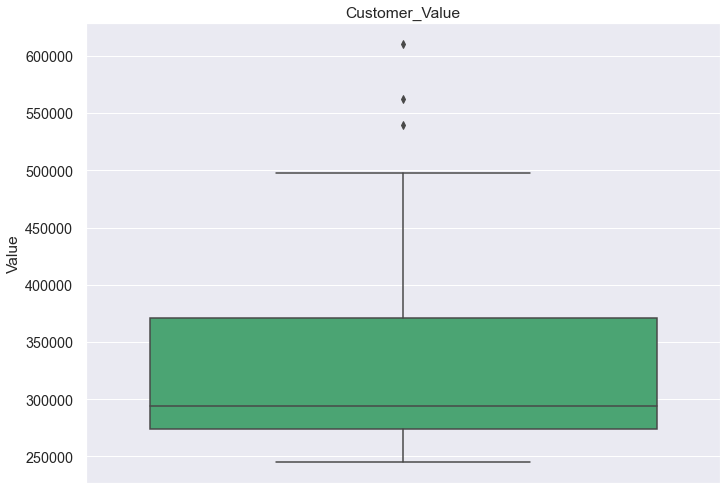

In [68]:
box_plot(df4.loc[outlier_indices, :,], 'Customer_Value')

In [69]:
print("Before: {} rows".format(len(df4)))
outliers = df4.loc[outlier_indices, :]
outliers['Outlier_Indicator'] = 'Yes'
outliers = outliers['Outlier_Indicator']
df5 = df4.join(outliers)
df5 = df5.loc[df5['Outlier_Indicator'].isnull()]
df5.drop(columns='Outlier_Indicator', inplace=True)
print("After: {} rows".format(len(df5)))

Before: 4726 rows
After: 4671 rows


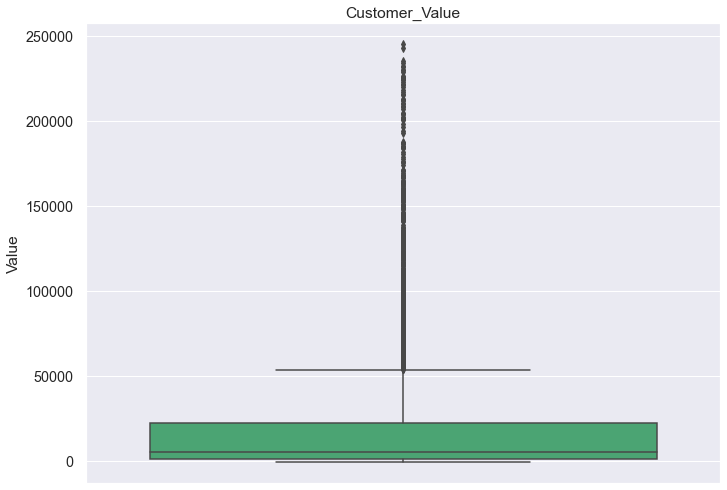

In [70]:
box_plot(df5, 'Customer_Value')

## Review Correlated Features to Customer Value

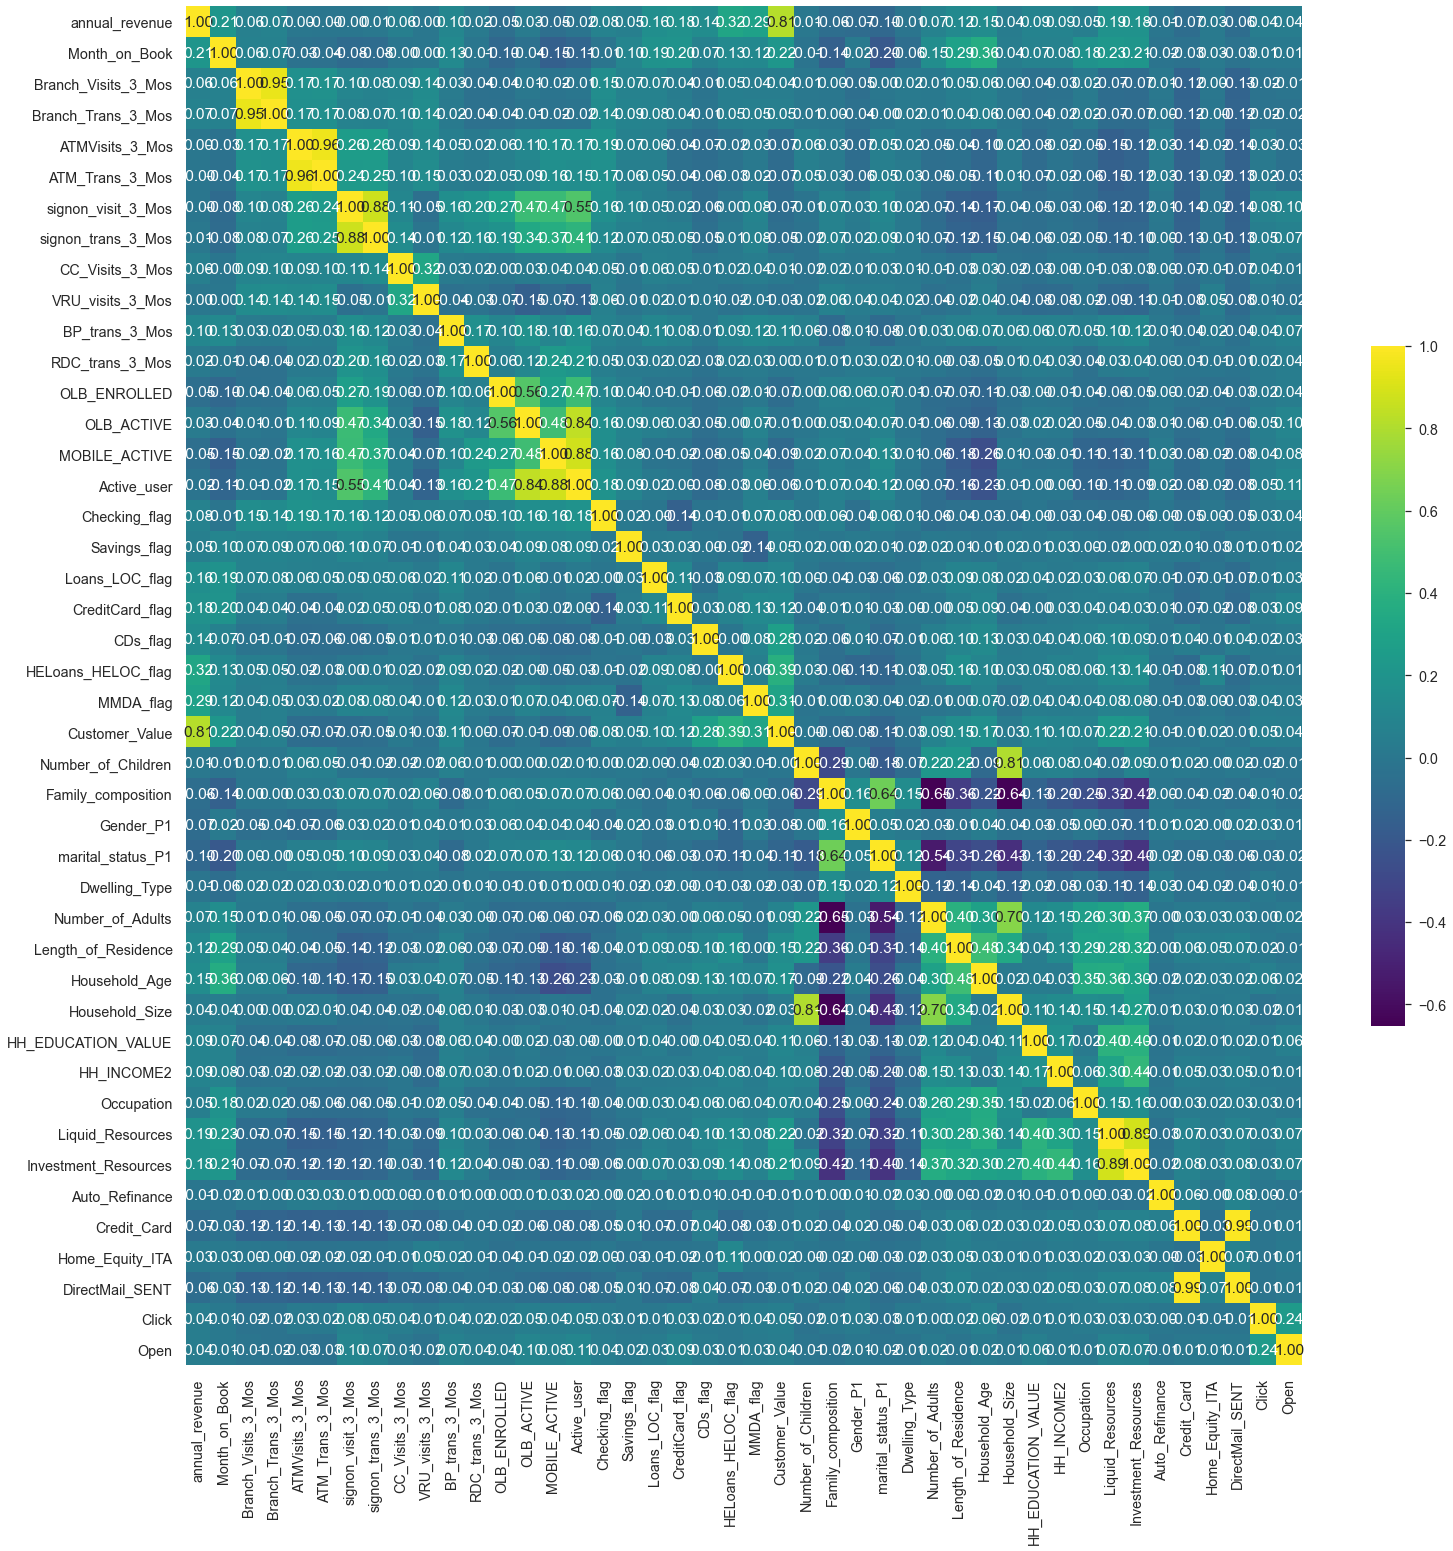

In [71]:
def corrplot(df):
    plt.figure(figsize = (25,25))
    sns.set(font_scale = 1.3)
    sns.heatmap(df.corr(), 
                annot = True, 
                fmt = '.2f',
                cmap= 'viridis',
                cbar_kws={'shrink': .5})
    
corrplot(df5)

In [72]:
# Output any correlation values over 0.65 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.65:
            print(index,value)
            
high_corr_and_check(df5)

('Credit_Card', 'DirectMail_SENT') 0.9927113959385019
('ATMVisits_3_Mos', 'ATM_Trans_3_Mos') 0.9610015834163214
('Branch_Visits_3_Mos', 'Branch_Trans_3_Mos') 0.9452337141508776
('Liquid_Resources', 'Investment_Resources') 0.8874844608491267
('MOBILE_ACTIVE', 'Active_user') 0.8775054201804149
('signon_visit_3_Mos', 'signon_trans_3_Mos') 0.8761201159374133
('OLB_ACTIVE', 'Active_user') 0.8449150974365783
('annual_revenue', 'Customer_Value') 0.8144857823296856
('Number_of_Children', 'Household_Size') 0.8053891097299597
('Number_of_Adults', 'Household_Size') 0.6975079200469921
('Family_composition', 'Number_of_Adults') 0.6516167829552736


## Visualisations

In [73]:
df6 = df5

In [74]:
df_numeric = df6.select_dtypes(include='number')
df6[df_numeric.columns] = df6[df_numeric.columns].astype(int)
df6[df_numeric.columns[12:]] = df6[df_numeric.columns[12:]].astype(str)
df6['Customer_Value'] = df6['Customer_Value'].astype(float)

In [75]:
binary_cols=[]
multi_Value=[]
for col in df6.columns:
    if df6[col].dtype =='object':
        if df6[col].unique().shape[0]==2:
            binary_cols.append(col)
        else:
            multi_Value.append(col)
            
binary_cols

['OLB_ENROLLED',
 'OLB_ACTIVE',
 'MOBILE_ACTIVE',
 'Checking_flag',
 'Savings_flag',
 'Loans_LOC_flag',
 'CreditCard_flag',
 'CDs_flag',
 'HELoans_HELOC_flag',
 'MMDA_flag',
 'Gender_P1',
 'Auto_Refinance',
 'Credit_Card',
 'Home_Equity_ITA',
 'DirectMail_SENT',
 'Click',
 'Open']

In [76]:
multi_Value

['Active_user',
 'Number_of_Children',
 'Family_composition',
 'marital_status_P1',
 'Dwelling_Type',
 'Number_of_Adults',
 'Length_of_Residence',
 'Household_Age',
 'Household_Size',
 'HH_EDUCATION_VALUE',
 'HH_INCOME2',
 'Occupation',
 'Liquid_Resources',
 'Investment_Resources']

In [77]:
df6['Gender_P1'] = df6['Gender_P1'].replace({'1':'Male', '2':'Female'})
df6[binary_cols] = df6[binary_cols].replace({'0':'No', '1':'Yes'})

In [78]:
for col in df6.dtypes[df6.dtypes == object].index:
    print(col,'\n', df6[col].unique())

OLB_ENROLLED 
 ['Yes' 'No']
OLB_ACTIVE 
 ['Yes' 'No']
MOBILE_ACTIVE 
 ['No' 'Yes']
Active_user 
 ['1' '2' '0']
Checking_flag 
 ['Yes' 'No']
Savings_flag 
 ['No' 'Yes']
Loans_LOC_flag 
 ['No' 'Yes']
CreditCard_flag 
 ['No' 'Yes']
CDs_flag 
 ['No' 'Yes']
HELoans_HELOC_flag 
 ['No' 'Yes']
MMDA_flag 
 ['No' 'Yes']
Number_of_Children 
 ['0' '2' '4' '3' '6' '1' '5' '7' '8' '9']
Family_composition 
 ['8' '14' '6' '2' '7' '1' '12' '3' '11' '4' '13' '5' '10' '16']
Gender_P1 
 ['Female' 'Male']
marital_status_P1 
 ['1' '2' '3']
Dwelling_Type 
 ['1' '5' '0' '2' '3' '6']
Number_of_Adults 
 ['2' '1' '5' '3' '4']
Length_of_Residence 
 ['7' '8' '4' '5' '6' '3' '1' '2']
Household_Age 
 ['7' '5' '4' '2' '3' '6' '1']
Household_Size 
 ['2' '1' '3' '4' '6' '8' '9' '5' '7']
HH_EDUCATION_VALUE 
 ['4' '2' '3' '5' '1' '0']
HH_INCOME2 
 ['6' '2' '4' '5' '7' '3' '8' '9' '1']
Occupation 
 ['14' '0' '6' '10' '5' '9' '12' '20' '18' '8' '13' '19' '2' '7' '17' '15']
Liquid_Resources 
 ['8' '5' '1' '7' '2' '11' '4' '

### Binary Variables Assessment

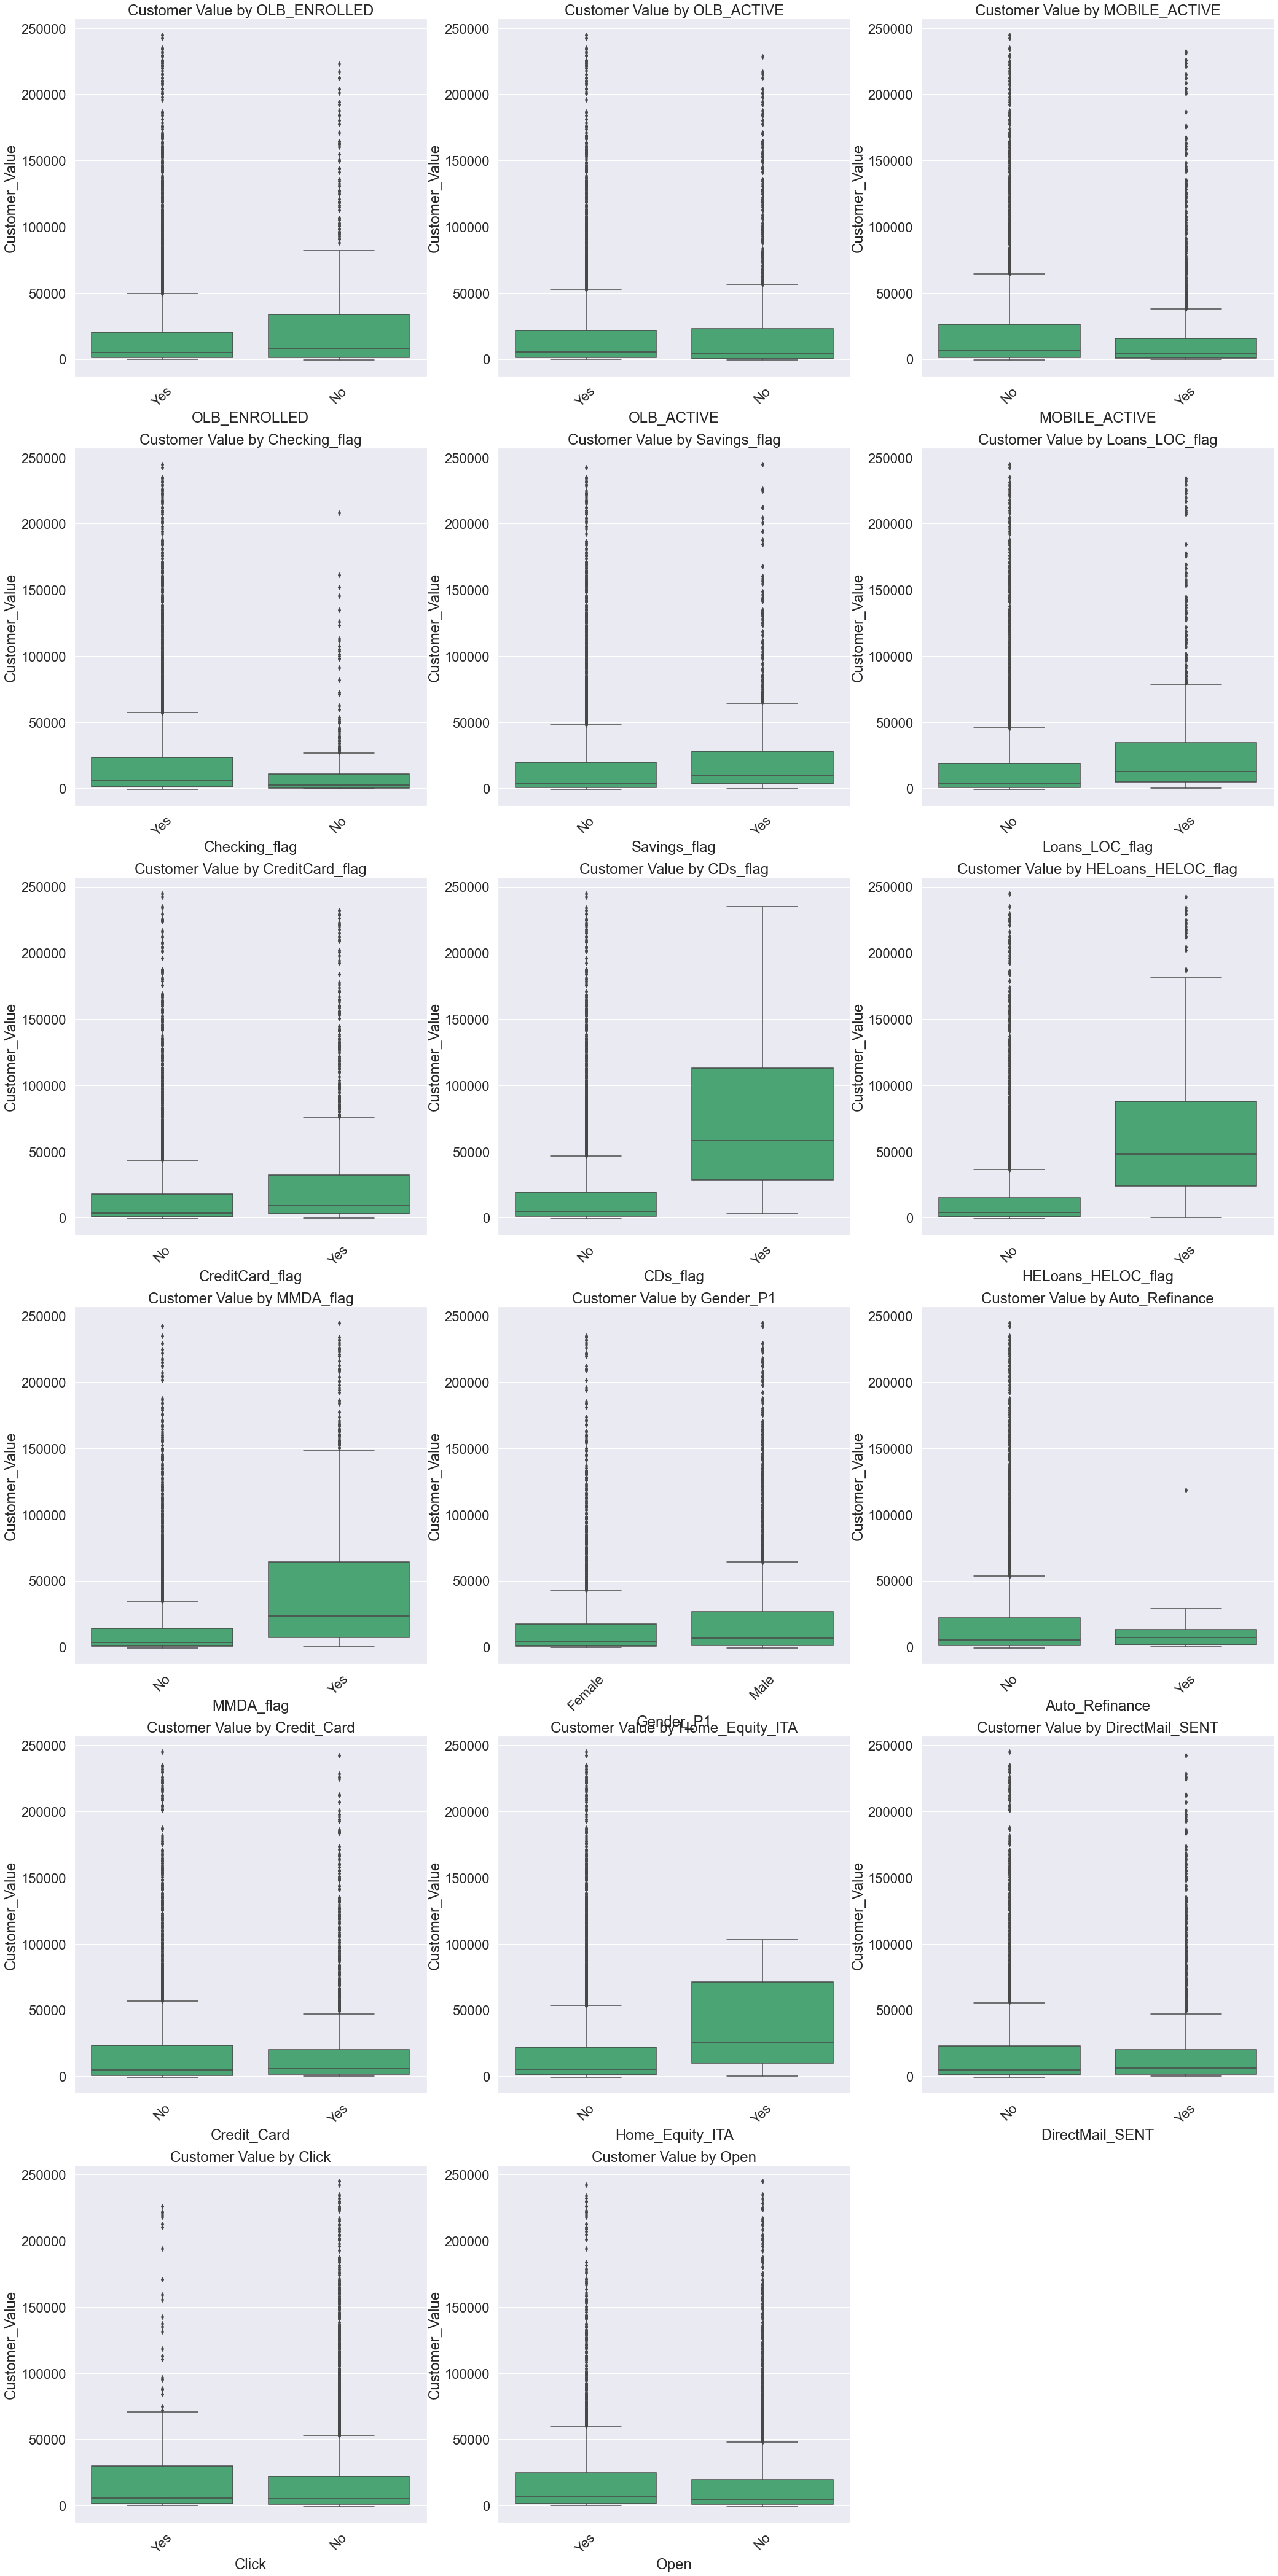

In [79]:
feature_num = list(enumerate(df6[binary_cols].columns))
feature_num

plt.figure(figsize = (35,75))
sns.set(font_scale = 2)

for i in feature_num:
    plt.subplot(6,3,i[0]+1)
    sns.boxplot(x = i[1],
                y='Customer_Value',
                data = df6,
                color='mediumseagreen',
                orient='v')
    
#     plt.ylabel('Customer Count')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

Some notable columns that stood out include:
+ CDs_flag
+ HELoans_HELOC_flag
+ MMDA_flag
+ Home_Equity_ITA

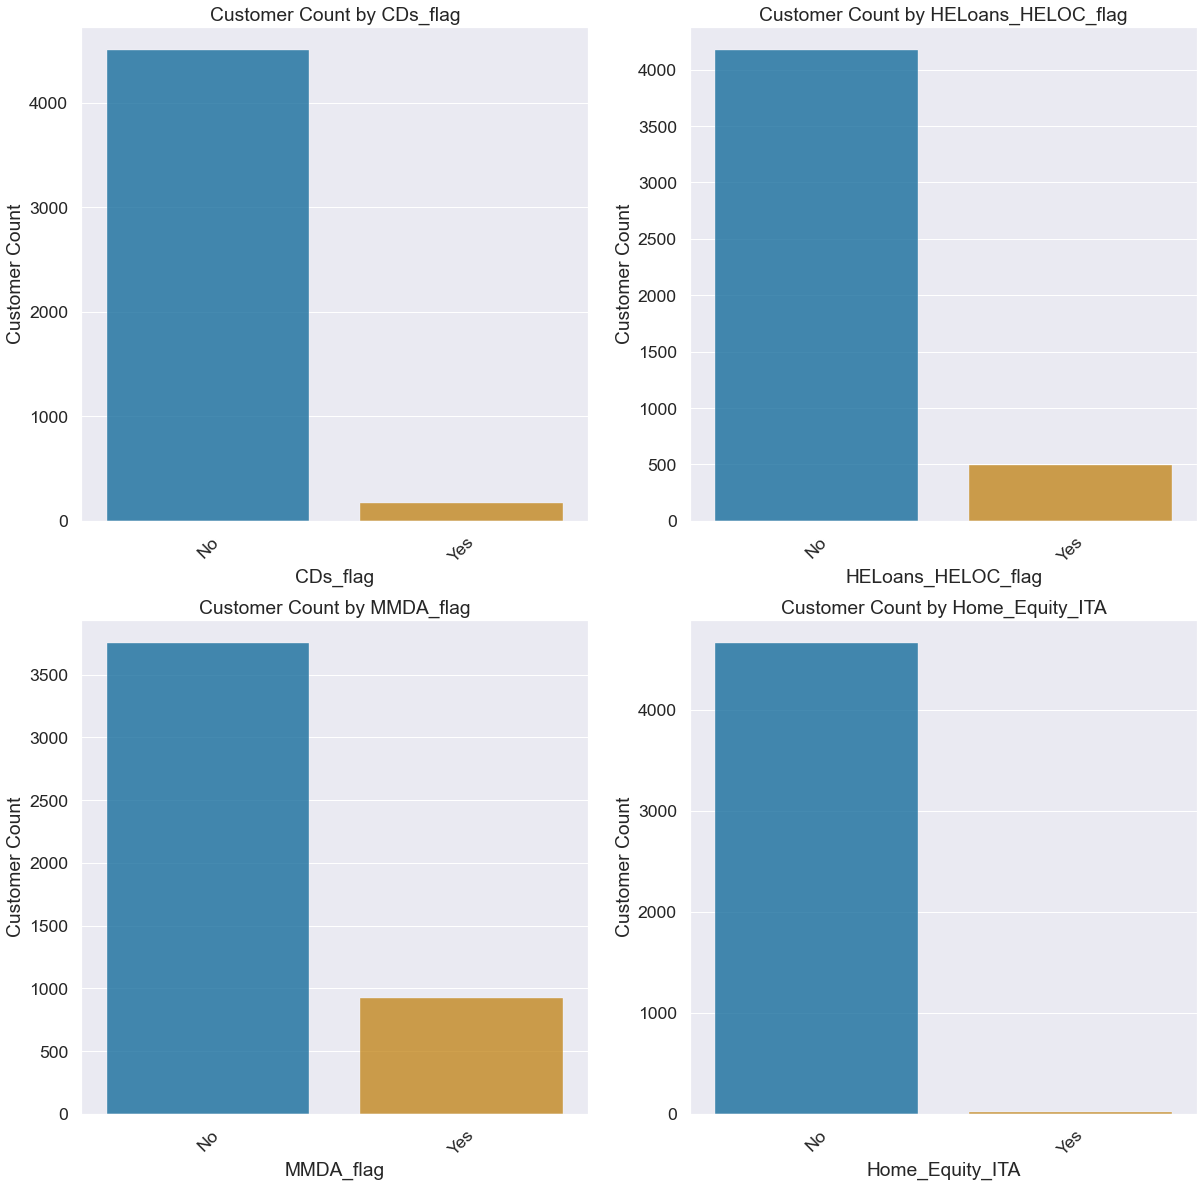

In [80]:
feature_obj = list(enumerate(df6[['CDs_flag', 
                                 'HELoans_HELOC_flag', 
                                 'MMDA_flag',
                                 'Home_Equity_ITA']].columns))


plt.figure(figsize = (20,20))
sns.set(font_scale = 1.6)

for i in feature_obj:
    num_cols = 2
    num_rows = 2
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.countplot(x = i[1],
                  data = df6,
                  palette='colorblind',
                  linewidth=0.4,
                  alpha=0.8
                 )
    
    plt.ylabel('Customer Count')
    plt.title('Customer Count by '+str(i[1]))
    plt.xticks(rotation = 45)

<b> Assessment: </b> The MMDA_flag and HELoans_HELOC_flag columns have significant numbers of the sample relative to the total that may be useful as a predictor in my model. For this reason, I will be considering its use as a variable.

### Multi-value Variables Assessment

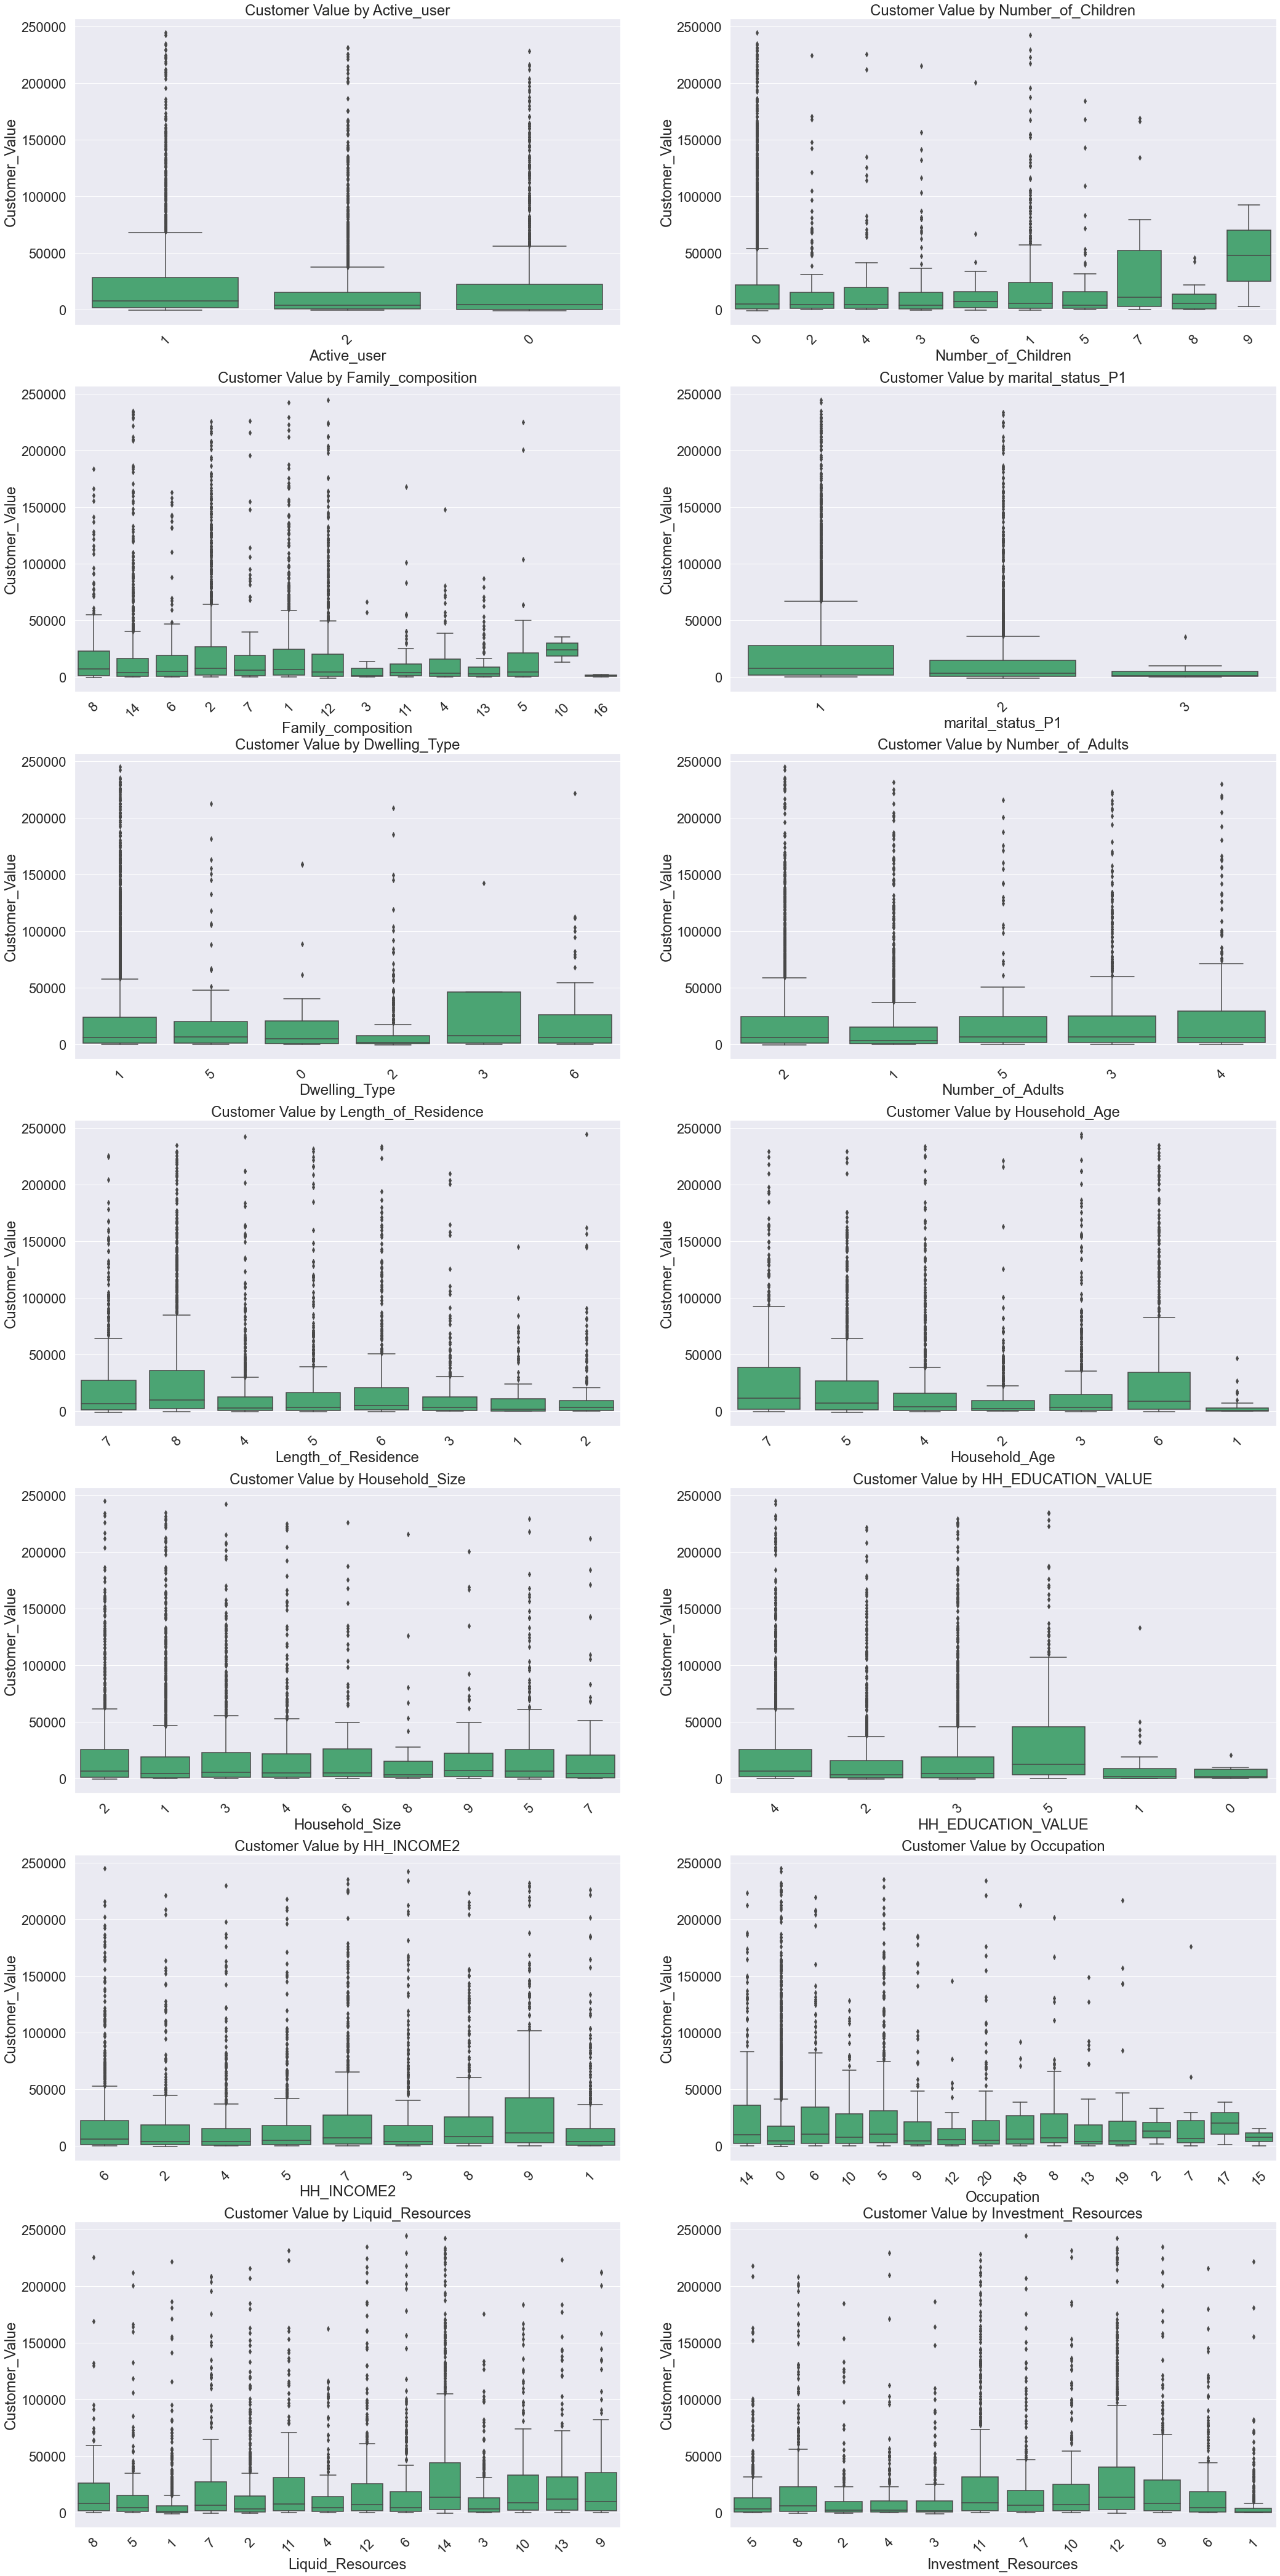

In [81]:
feature_num = list(enumerate(df6[multi_Value].columns))
feature_num

plt.figure(figsize = (35,75))
sns.set(font_scale = 2)

for i in feature_num:
    num_cols = 2
    num_rows = 7
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.boxplot(x = i[1],
                y='Customer_Value',
                data = df6,
                color='mediumseagreen',
                orient='v')
    
#     plt.ylabel('Customer Count')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

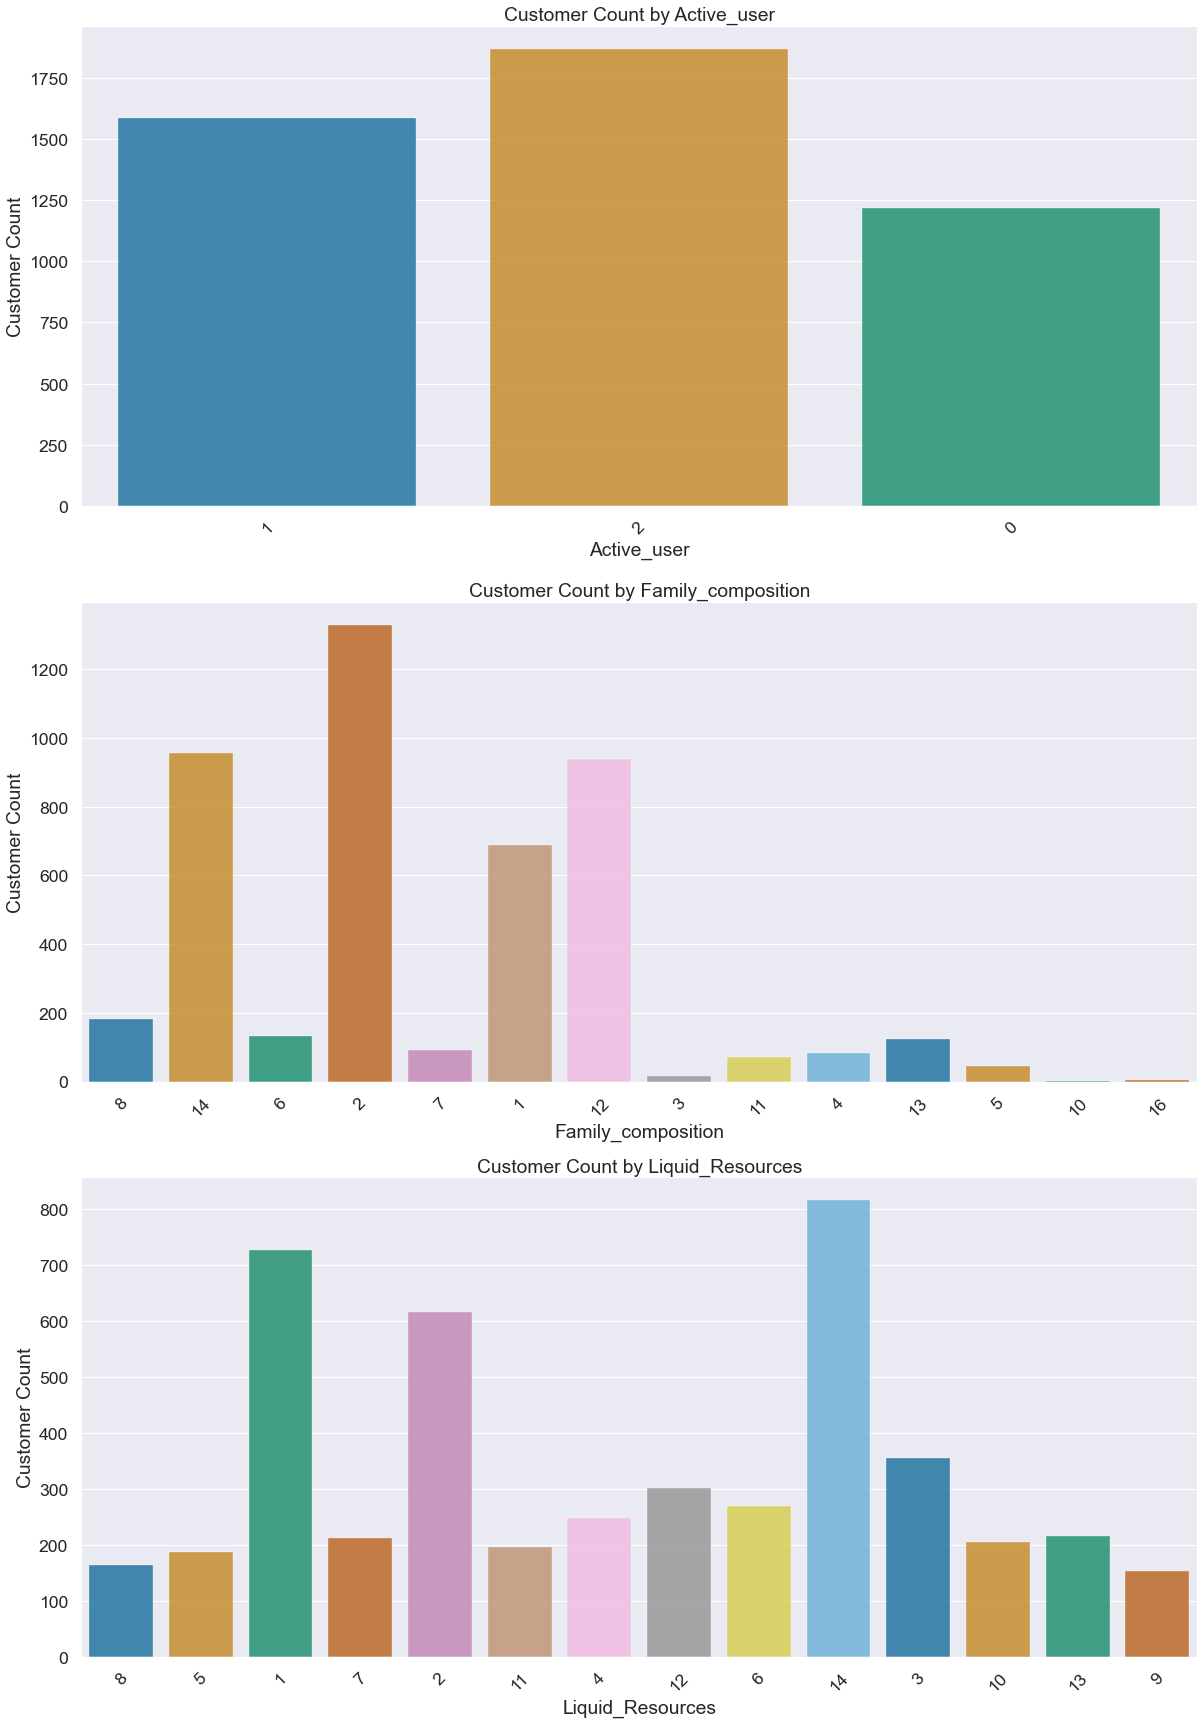

In [82]:
feature_obj = list(enumerate(df6[['Active_user','Family_composition','Liquid_Resources']].columns))


plt.figure(figsize = (20,30))
sns.set(font_scale = 1.6)

for i in feature_obj:
    num_cols = 1
    num_rows = 3
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.countplot(x = i[1],
                  data = df6,
                  palette='colorblind',
                  linewidth=0.4,
                  alpha=0.8
                 )
    
    plt.ylabel('Customer Count')
    plt.title('Customer Count by '+str(i[1]))
    plt.xticks(rotation = 45)

<b> Assessment: </b> The Active user, Liquid_Resources, and Family_composition columns looks to be potentially useful. For this reason, I will be considering its use as a variable.

### Numeric Variables Assessment

In [83]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4671 entries, 763 to 6060102
Data columns (total 44 columns):
annual_revenue          4671 non-null int32
Month_on_Book           4671 non-null int32
Branch_Visits_3_Mos     4671 non-null int32
Branch_Trans_3_Mos      4671 non-null int32
ATMVisits_3_Mos         4671 non-null int32
ATM_Trans_3_Mos         4671 non-null int32
signon_visit_3_Mos      4671 non-null int32
signon_trans_3_Mos      4671 non-null int32
CC_Visits_3_Mos         4671 non-null int32
VRU_visits_3_Mos        4671 non-null int32
BP_trans_3_Mos          4671 non-null int32
RDC_trans_3_Mos         4671 non-null int32
OLB_ENROLLED            4671 non-null object
OLB_ACTIVE              4671 non-null object
MOBILE_ACTIVE           4671 non-null object
Active_user             4671 non-null object
Checking_flag           4671 non-null object
Savings_flag            4671 non-null object
Loans_LOC_flag          4671 non-null object
CreditCard_flag         4671 non-null object
CDs_f

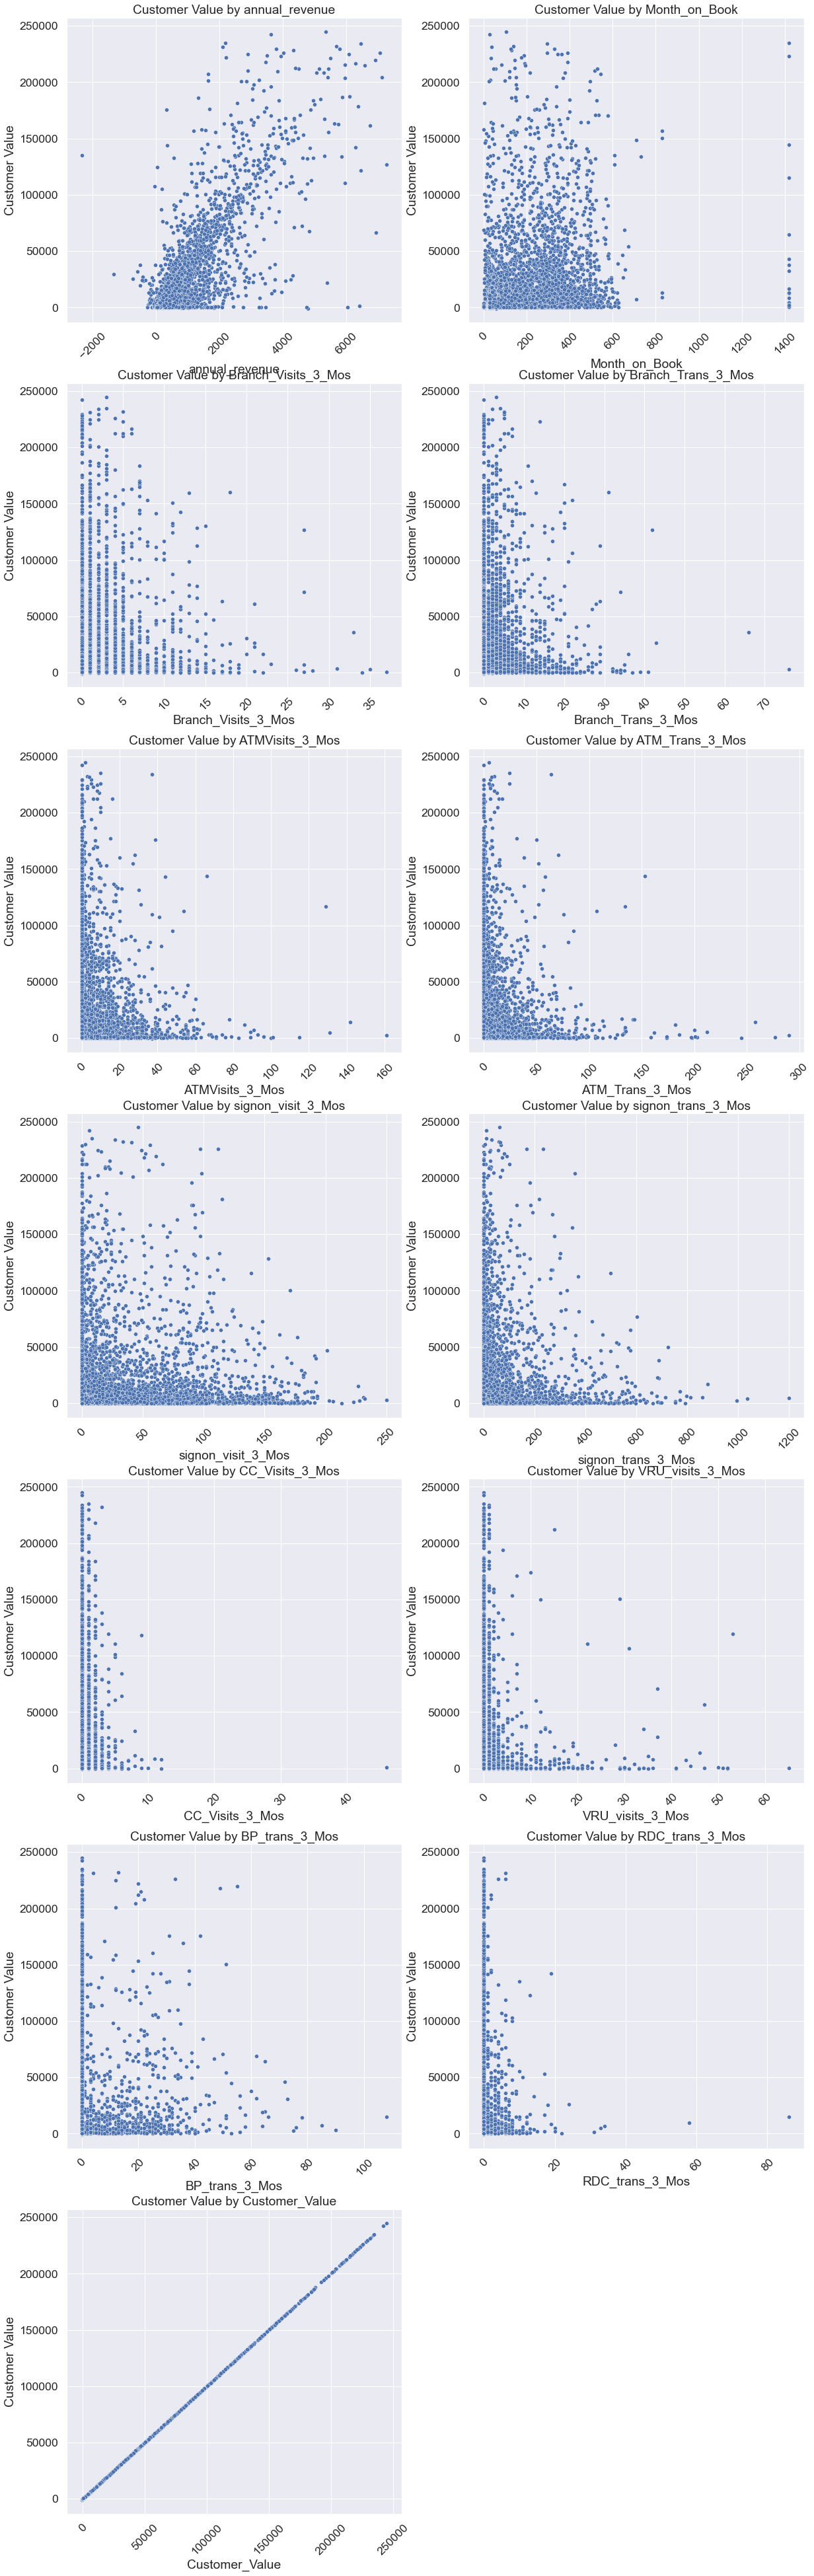

In [84]:
#select non-numeric variables
df_numeric = df6.select_dtypes(include='number')
#select the column names and convert to a list
df_numeric_columns = list(df_numeric.columns)
#select the columns, excluding the first two (Churn & ServiceAreaCode)
feature_obj = list(enumerate(df_numeric_columns))


plt.figure(figsize = (20,100))
sns.set(font_scale = 1.6)

for i in feature_obj:
    num_cols = 2
    num_rows = 10
    plt.subplot(num_rows,num_cols,i[0]+1)
    sns.scatterplot(data = df6,
                  x = i[1],
                  y='Customer_Value',
                  palette='colorblind',
                  linewidth=0.4
                 )
    
    plt.ylabel('Customer Value')
    plt.title('Customer Value by '+str(i[1]))
    plt.xticks(rotation = 45)

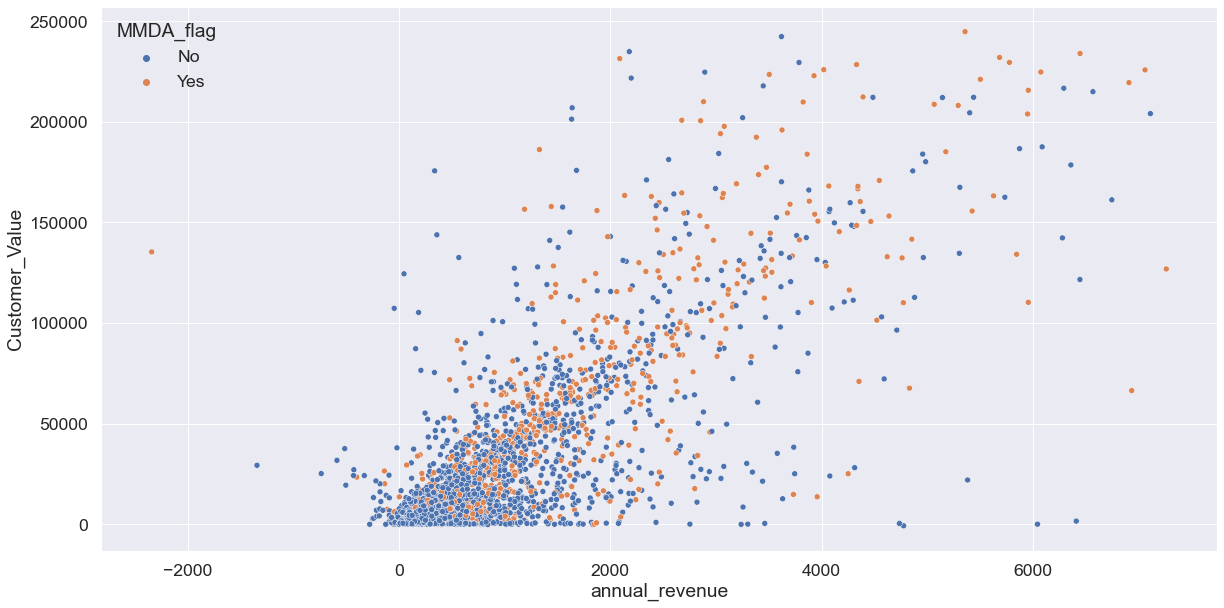

In [85]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 1.6)
sns.scatterplot(data=df6, x="annual_revenue", y="Customer_Value", hue='MMDA_flag')

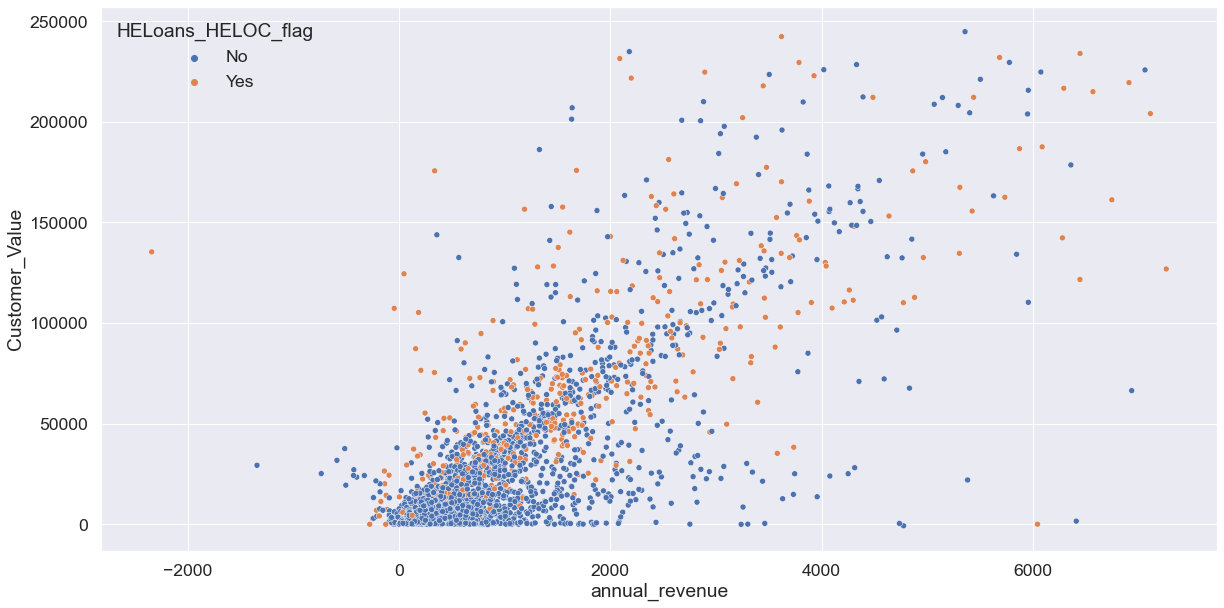

In [86]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 1.6)
sns.scatterplot(data=df6, x="annual_revenue", y="Customer_Value", hue='HELoans_HELOC_flag')

<b> Assessment: </b> At first pass, some predictor variables I anticipate using are:

+ HELoans_HELOC_flag
+ Active User
+ MMDA_flag
+ annual_revenue

Below is the first initial pass at using a linear regression model using all variables as predictors.

In [87]:
df5.shape

(4671, 44)

In [88]:
list(df5.columns)

['annual_revenue',
 'Month_on_Book',
 'Branch_Visits_3_Mos',
 'Branch_Trans_3_Mos',
 'ATMVisits_3_Mos',
 'ATM_Trans_3_Mos',
 'signon_visit_3_Mos',
 'signon_trans_3_Mos',
 'CC_Visits_3_Mos',
 'VRU_visits_3_Mos',
 'BP_trans_3_Mos',
 'RDC_trans_3_Mos',
 'OLB_ENROLLED',
 'OLB_ACTIVE',
 'MOBILE_ACTIVE',
 'Active_user',
 'Checking_flag',
 'Savings_flag',
 'Loans_LOC_flag',
 'CreditCard_flag',
 'CDs_flag',
 'HELoans_HELOC_flag',
 'MMDA_flag',
 'Customer_Value',
 'Number_of_Children',
 'Family_composition',
 'Gender_P1',
 'marital_status_P1',
 'Dwelling_Type',
 'Number_of_Adults',
 'Length_of_Residence',
 'Household_Age',
 'Household_Size',
 'HH_EDUCATION_VALUE',
 'HH_INCOME2',
 'Occupation',
 'Liquid_Resources',
 'Investment_Resources',
 'Auto_Refinance',
 'Credit_Card',
 'Home_Equity_ITA',
 'DirectMail_SENT',
 'Click',
 'Open']

# Identify and Assess Predictors for Data Model

In [89]:
df5['Gender_P1'] = df5['Gender_P1'].replace({'Male':'1', 'Female':'2'})
df5[binary_cols] = df5[binary_cols].replace({'No':'0', 'Yes':'1'})
objects = df5.select_dtypes(exclude='number')
df5[objects.columns] = df5[objects.columns].astype(float)
numnbers = df5.select_dtypes(include='number')
df5[numnbers.columns] = df5[numnbers.columns].astype(float)

In [90]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4671 entries, 763 to 6060102
Data columns (total 44 columns):
annual_revenue          4671 non-null float64
Month_on_Book           4671 non-null float64
Branch_Visits_3_Mos     4671 non-null float64
Branch_Trans_3_Mos      4671 non-null float64
ATMVisits_3_Mos         4671 non-null float64
ATM_Trans_3_Mos         4671 non-null float64
signon_visit_3_Mos      4671 non-null float64
signon_trans_3_Mos      4671 non-null float64
CC_Visits_3_Mos         4671 non-null float64
VRU_visits_3_Mos        4671 non-null float64
BP_trans_3_Mos          4671 non-null float64
RDC_trans_3_Mos         4671 non-null float64
OLB_ENROLLED            4671 non-null float64
OLB_ACTIVE              4671 non-null float64
MOBILE_ACTIVE           4671 non-null float64
Active_user             4671 non-null float64
Checking_flag           4671 non-null float64
Savings_flag            4671 non-null float64
Loans_LOC_flag          4671 non-null float64
CreditCard_flag    

In [91]:
pd.value_counts(df5['Active_user'], dropna=False)

2.00    1867
1.00    1585
0.00    1219
Name: Active_user, dtype: int64

In [92]:
model = sm.OLS.from_formula("Customer_Value ~ annual_revenue + MMDA_flag + Active_user + HELoans_HELOC_flag", data=df5)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Customer_Value   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2596.
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:11:55   Log-Likelihood:                -53037.
No. Observations:                4671   AIC:                         1.061e+05
Df Residuals:                    4666   BIC:                         1.061e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1085.5803    573

In [93]:
selected_col = ['annual_revenue', 
                'MMDA_flag', 
                'Active_user', 
                'HELoans_HELOC_flag']

target = df5[['Customer_Value']]

X = df5[selected_col]
y = target

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

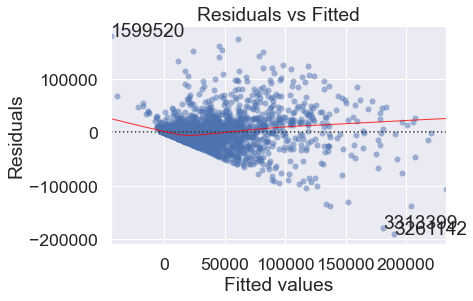

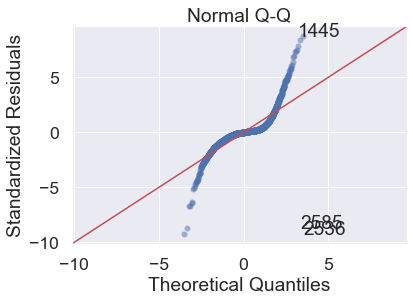

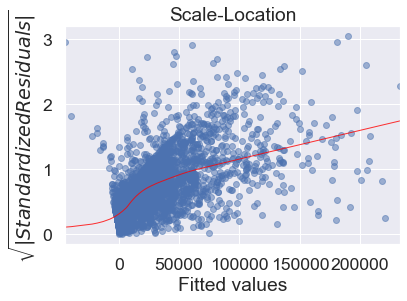

In [94]:
diagnostic_plots(X, y, model_fit=None)

# END